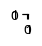

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline
from src.bootstrap import get_pval, plot_pval
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

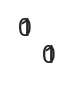

In [3]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [4]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_curve_auc(df, targetcol, scorecol, neg=False):
    if neg:
        fpr, tpr, _ = roc_curve(df[targetcol], -1* df[scorecol])
        auc = roc_auc_score(df[targetcol], -1* df[scorecol])
        auc01 = roc_auc_score(df[targetcol], -1* df[scorecol], max_fpr=0.1)
    else:
        fpr, tpr, _ = roc_curve(df[targetcol], df[scorecol])
        auc = roc_auc_score(df[targetcol], df[scorecol])
        auc01 = roc_auc_score(df[targetcol], df[scorecol], max_fpr=0.1)
    return fpr, tpr, auc, auc01

In [6]:
import itertools
mcs = []
cols_ = ['icore_aliphatic_index', 'icore_boman', 'icore_hydrophobicity', 'icore_isoelectric_point', 'icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM'] 


for L in range(0, len(cols_) + 1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
len(mcs)


1024

In [7]:
key = '-'.join(cols_)
key = 'all_feats' if key == '-'.join(cols_) else key
key

'all_feats'

# init

## reloading datasets

In [6]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [291]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230308_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230308_nepdb_aligned_icore.csv')

In [292]:
cedar_expr = pd.read_csv('../data/pepx/230308_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230308_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230308_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230308_nepdb_normal_pepx.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/pepx/230308_cedar_related_pepx_fold.csv'

In [9]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

In [10]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

<AxesSubplot:>

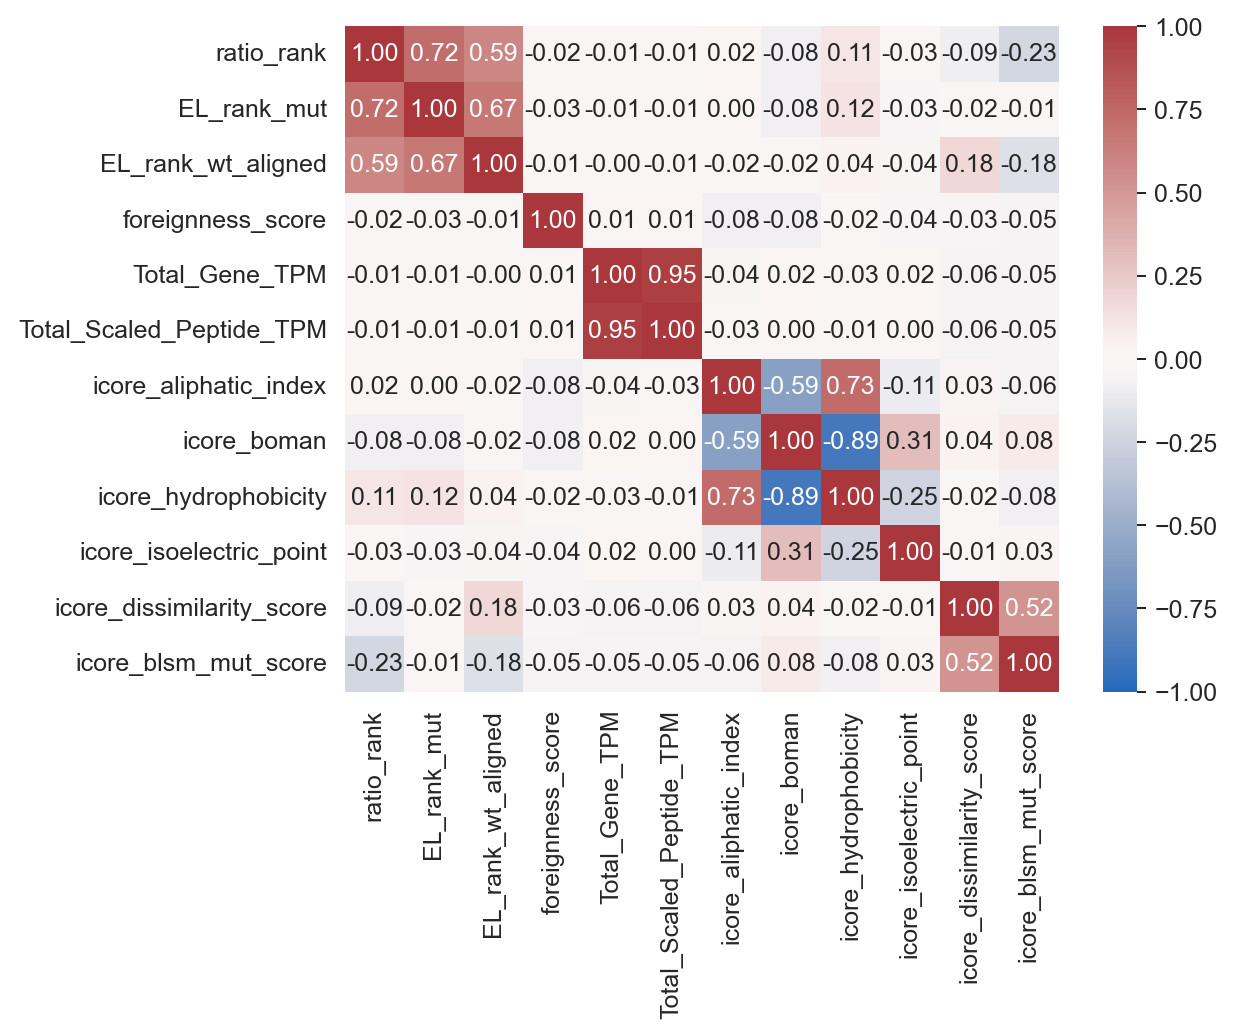

In [11]:
from scipy.stats import ttest_ind, mannwhitneyu
xd, _ = get_aa_properties(cedar_aligned_expr, 'icore_mut', False, 'icore_')
features=['ratio_rank', 'EL_rank_mut', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM', 'Total_Scaled_Peptide_TPM', 'icore_aliphatic_index', 'icore_boman', 'icore_hydrophobicity', 'icore_isoelectric_point', 'icore_dissimilarity_score', 'icore_blsm_mut_score']
corr= xd[features].corr(method='spearman')
sns.heatmap(corr, center=0, vmin=-1, vmax=1, cmap='vlag', annot=True, fmt='.2f')

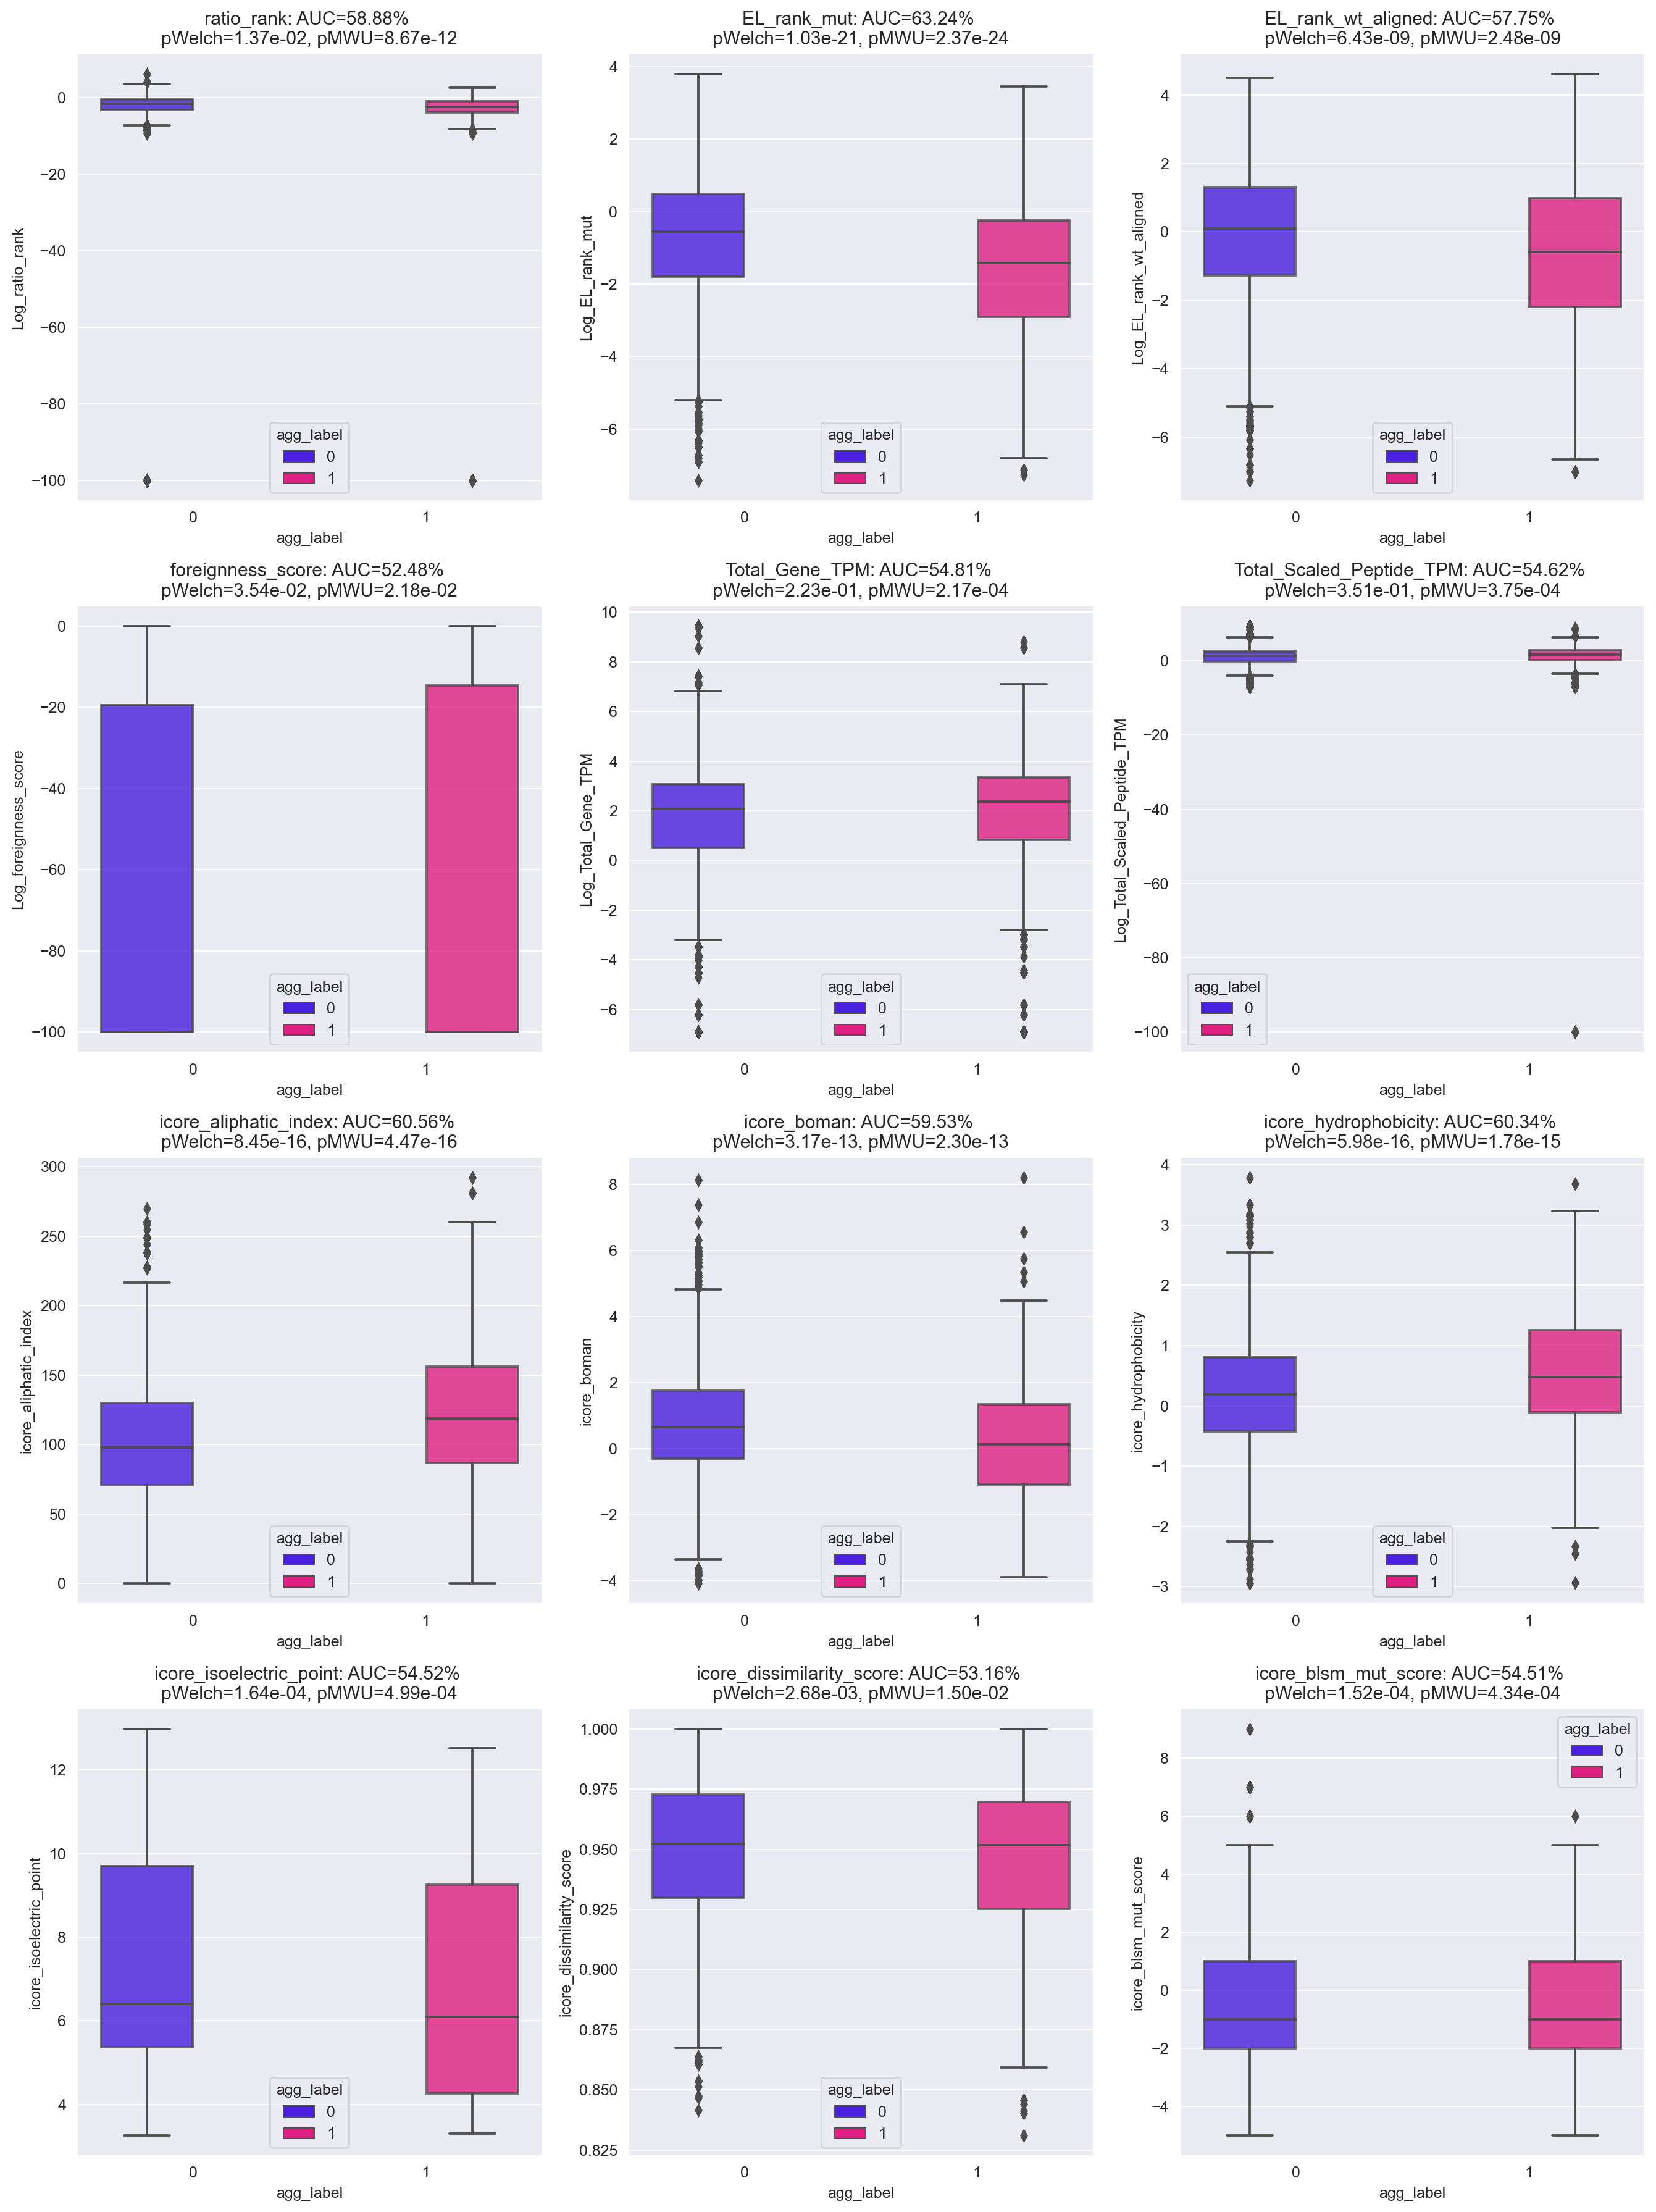

In [14]:
f,a = plt.subplots(4,3, figsize=(15,20))
a = a.ravel()
for feat, ax in zip(features, a.ravel()):
    if 'icore' not in feat:
        xd[f'Log_{feat}'] = xd[feat].apply(np.log)
        xd[f'Log_{feat}'].replace(-np.inf, -100,inplace=True)
        sns.boxplot(data=xd, y=f'Log_{feat}', x='agg_label', hue='agg_label', ax=ax)
        plt.setp(ax.patches, alpha=0.8)
        # sns.swarmplot(data=xd, y=f'Log_{feat}', x='agg_label', hue='agg_label', ax=ax, size=3, edgecolor='k', dodge=True)
        ax.set_ylabel(f'Log_{feat}')
        a=xd.query('agg_label==0')[f'Log_{feat}'].values
        b=xd.query('agg_label==1')[f'Log_{feat}'].values
        if 'rank' in feat:
            auc = roc_auc_score(xd.agg_label.values, 1-xd[f'Log_{feat}'].values)
        else:
            auc = roc_auc_score(xd.agg_label.values, xd[f'Log_{feat}'].values)
    else:
        sns.boxplot(data=xd, y=feat, x='agg_label', hue='agg_label', ax=ax)
        plt.setp(ax.patches, alpha=0.8)
        # sns.swarmplot(data=xd, y=feat, x='agg_label', hue='agg_label', ax=ax,  size=3, edgecolor='k', dodge=True)
        a=xd.query('agg_label==0')[feat].values
        b=xd.query('agg_label==1')[feat].values
        if any([x in feat for x in ['boman', 'dissim', 'blsm', 'isoelectric']]):
            auc = roc_auc_score(xd.agg_label.values, 1-xd[feat].values)
        else:
            auc = roc_auc_score(xd.agg_label.values, xd[feat].values)

    pvalw = ttest_ind(a,b, equal_var=False)[1]
    pvalmwu = mannwhitneyu(a,b)[1]
    ax.set_title(f'{feat}: AUC={auc:.2%} \npWelch={pvalw:.2e}, pMWU={pvalmwu:.2e}')
f.tight_layout()

# DETOUR: BUGFIX FOR PU LEARNING


In [377]:
from src.data_processing import encode_batch_weighted, encode_batch

In [302]:
train = cedar_aligned_expr.query('fold != 5 and fold != 7')

In [304]:
tmp = pd.concat([train.query('agg_label==1'), train.query('agg_label==0').sample(frac=1.0, random_state=3, replace=True)])

In [361]:
encoding_kwargs = {'max_len': 12, 'encoding': 'onehot', 'blosum_matrix': 'None', 'add_rank': True, 'seq_col': 'icore_mut', 'rank_col': 'EL_rank_mut',
                   'target_col': 'agg_label', 'hla_col': 'HLA', 'add_aaprop': False, 'remove_pep': False, 'mask': False, 'invert': False, 'mut_col': ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank', 'Total_Gene_TPM']} 

get_dataset(tmp.query('icore_len_mut<12'), None, **encoding_kwargs)
get_dataset(tmp.query('icore_len_mut>=11'), None, **encoding_kwargs)

ValueError: operands could not be broadcast together with shapes (184,20) (183,1) 

In [393]:
import torch
xr = torch.from_numpy(np.random.rand(3, 12, 20))
xr[0, 9:, :] = 0
xr[2, 10:, :] = 0
mask = (xr == 0).all(2)
true_lens = (mask.shape[1] - torch.bincount(torch.where(mask)[0])).unsqueeze(1) if type(mask) == torch.Tensor else \
        np.expand_dims(mask.shape[1] - np.bincount(np.where(mask)[0]), 1)
true_lens, torch.bincount(torch.where(mask)[0])

(tensor([[ 9],
         [12],
         [10]]),
 tensor([3, 0, 2]))

In [394]:
import torch
xr = torch.from_numpy(np.random.rand(3, 12, 20))
xr[0, 9:, :] = 0
xr[1, 10:, :] = 0
mask = (xr == 0).all(2)
true_lens = (mask.shape[1] - torch.bincount(torch.where(mask)[0])).unsqueeze(1) if type(mask) == torch.Tensor else \
        np.expand_dims(mask.shape[1] - np.bincount(np.where(mask)[0]), 1)
true_lens, torch.bincount(torch.where(mask)[0])

(tensor([[ 9],
         [10]]),
 tensor([3, 2]))

In [395]:
tmp['seq_len'] = tmp['icore_mut'].apply(len)
true_lens = tmp['seq_len'].values

In [387]:
# SO SOMEHOW THIS BUG ONLY OCCURS IF THE PROBLEMATIC (I.E. LEN == MAXLEN) IS THE LAST ELEMENT OF THE ARRAY
# how the FUCK does this even happen, if it's the last element the instead of returning 0 it returns a missing element like what the FUCK
# HOTFIX : Just give the truelens as a vector like I did in the other branch..a
tmp

,Unnamed: 0,Peptide,HLA,EL_rank_mut,agg_label,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,...,icore_mutation_position,icore_wt_aligned,isoelectric_point,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank
12,12,AATPVGSLY,HLA-B4002,11.1987,1,0,8.8607,8.8607,9.121050,9.121,...,7,AATPVGSSY,6.093198,9,9,>seq_13,11.1987,AATPVGSSY,7.619771e-03,1.263862
28,28,AGQHIAKSLF,HLA-B4402,1.9036,1,4,3.4639,3.4639,357.574000,357.574,...,7,GQHIAKSPF,9.702002,10,9,>seq_29,4.1901,AGQHIAKSPF,3.475804e-09,0.549554
47,47,ALALAQKGV,HLA-A0201,1.0758,1,6,2.9565,2.9565,24.591700,24.592,...,5,ALALARKGV,9.700003,9,9,>seq_48,1.0758,ALALARKGV,2.668819e-11,0.363876
61,61,ALDPHSGHFV,HLA-A0201,0.0854,1,4,11.6410,11.6410,106.603000,106.603,...,1,ARDPHSGHFV,6.496504,10,10,>seq_62,0.0854,ARDPHSGHFV,4.526800e-07,0.007336
62,62,ALDPHSGHFVA,HLA-A0201,0.0854,1,4,11.6410,11.6410,106.603000,106.603,...,1,ARDPHSGHFV,6.496504,11,10,>seq_63,1.4716,ARDPHSGHFVA,4.526800e-07,0.007336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,238,AYFLPRPPL,HLA-B0702,1.9033,0,2,1.0967,1.0967,8.741010,8.741,...,3,AYFPPRPPL,9.348808,9,9,>seq_244,1.9033,AYFPPRPPL,1.000000e+00,1.735479
2132,2132,SAWTDTQRL,HLA-A0201,3.3866,0,9,28.4074,28.4074,30.121000,30.121,...,8,SAWTDTQRS,6.338719,9,9,>seq_2169,3.3866,SAWTDTQRS,0.000000e+00,0.119215
2762,2762,WLRDHRMTGL,HLA-B0702,1.4280,0,2,1.1898,1.1898,13.151000,13.151,...,7,WLRDHRMAGL,10.399535,10,10,>seq_2806,1.4280,WLRDHRMAGL,0.000000e+00,1.200202
549,549,FLYVLGRKK,HLA-A1101,1.8474,0,1,1.4569,1.4569,0.050998,0.051,...,4,FLYVVGRKK,10.901810,9,9,>seq_558,1.8474,FLYVVGRKK,0.000000e+00,1.268035


In [386]:
xd=get_dataset(cedar_aligned_expr.iloc[1968:1971], None, **encoding_kwargs)

In [370]:
xd2=get_dataset(cedar_aligned_expr.iloc[1968:1970], None, **encoding_kwargs)

In [396]:
xd3=get_dataset(cedar_aligned_expr.iloc[[1968]], None, **encoding_kwargs)

In [398]:
xd4 = get_dataset(tmp, None, **encoding_kwargs)

In [376]:
xd5 = get_dataset(cedar_aligned_expr.iloc[1967:2500], None, **encoding_kwargs)

# redo conditions

In [83]:
cdt_base = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, 
                       add_rank=True, seq_col='Peptide', rank_col='trueHLA_EL_rank', hla_col='HLA',
                       target_col = 'agg_label', add_aaprop=False, remove_pep=False, standardize=True),
            None, 'Base')
cdt_cedar = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['EL_rank_wt_aligned','icore_dissimilarity_score','ratio_rank','Total_Gene_TPM']
                        ), # Here it should be icore similarity score because it's not dissimilarity that we have
            ics_shannon, 'OptCEDAR')

cdt_prime = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=True, invert=False,
                        mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score']),
            ics_shannon, 'OptPRIME')

cdt_general = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                          add_aaprop=False, remove_pep=False, standardize=True,
                          mask=False, invert=False,
                          mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank', 'Total_Gene_TPM']),
             None, 'General')

In [17]:
encoding_kwargs = dict(max_len=12, encoding='onehot', rank_col='EL_rank_mut', seq_col='icore_mut',
                       blosum_matrix=None, mask=False, add_rank=True, add_aaprop=False, 
                       remove_pep=False, standardize=True)

def final_bootstrap_wrapper(preds_df, filename,
                            ic_name, key, evalset,
                            n_rounds=10000, n_jobs=8, outdir=None):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'icore_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['evalset'] = evalset.upper()
    if outdir is not None:
        bootstrapped_df.to_csv(
            f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
            index=False)
        pkl_dump(mean_rocs,
                 f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

In [103]:
# Quick individual checks for pvalues
from src.bootstrap import get_pval, plot_pval
# Redo CEDAR inv weighting vs none and get pval
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['icore_dissimilarity_score', 'Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have

comp = []
for ics_dict,weight in zip([ics_shannon, None], [None, 'None']):
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
    # Training model and getting feature importances
    print('Training')
    if weight=='None': 
        encoding_kwargs['invert']=False
        encoding_kwargs['mask']=False
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned_expr, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    _, preds = evaluate_trained_models_sklearn(cedar_aligned_expr.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               trained_models, ics_dict,
                                               cedar_aligned_expr,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8)
    bootstrapped_df = final_bootstrap_wrapper(preds, 'xd',
                                              weight, 'xd', 'CEDAR',
                                              n_rounds=10000, n_jobs=8, outdir=None)
    comp.append(bootstrapped_df)
    
get_pval(comp[0].auc.values, comp[1].auc.values), comp[0].auc.mean(), comp[1].auc.mean()

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


((0.04249999999999998, '*'), 0.7375124645540864, 0.7298803373018402)

In [138]:
from src.bootstrap import get_pval, plot_pval
# Redo CEDAR inv weighting vs none and get pval
a = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['icore_dissimilarity_score', 'Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have

b = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have


comp = []
for encoding_kwargs, ics_dict, cdt in zip([a,b], [ics_shannon, ics_shannon], ['A', 'B']):
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
    # Training model and getting feature importances
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned_expr, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    _, preds = evaluate_trained_models_sklearn(cedar_aligned_expr.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               trained_models, ics_dict,
                                               cedar_aligned_expr,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8)
    bootstrapped_df = final_bootstrap_wrapper(preds, 'A',
                                              weight, cdt, 'PRIME',
                                              n_rounds=10000, n_jobs=8, outdir=None)
    comp.append(bootstrapped_df)
print('cdt A (mask+icore scores) >> cdt B (None weighting + base features)')
get_pval(comp[0].auc.values, comp[1].auc.values), comp[0].auc.mean(), comp[1].auc.mean()

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
cdt A (mask+icore scores) >> cdt B (None weighting + base features)


((0.8634, 'ns'), 0.7375124645540864, 0.7389467447759966)

In [138]:
from src.bootstrap import get_pval, plot_pval
# Redo CEDAR inv weighting vs none and get pval
a = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['icore_dissimilarity_score', 'Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have

b = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['Total_Gene_TPM']
                        ) # Here it should be icore similarity score because it's not dissimilarity that we have


comp = []
for encoding_kwargs, ics_dict, cdt in zip([a,b], [ics_shannon, ics_shannon], ['A', 'B']):
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
    # Training model and getting feature importances
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned_expr, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    _, preds = evaluate_trained_models_sklearn(cedar_aligned_expr.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               trained_models, ics_dict,
                                               cedar_aligned_expr,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8)
    bootstrapped_df = final_bootstrap_wrapper(preds, 'A',
                                              weight, cdt, 'PRIME',
                                              n_rounds=10000, n_jobs=8, outdir=None)
    comp.append(bootstrapped_df)
print('cdt A (mask+icore scores) >> cdt B (None weighting + base features)')
get_pval(comp[0].auc.values, comp[1].auc.values), comp[0].auc.mean(), comp[1].auc.mean()

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
cdt A (mask+icore scores) >> cdt B (None weighting + base features)


((0.8634, 'ns'), 0.7375124645540864, 0.7389467447759966)

# Redo p-values

Redo this way: With the gb_merged thing, compare for each condition against the base model (icore, aafreq+ic(rank)?) or (peptide, aafreq+p(rank))?

In [216]:

# retrain the basest of base models: 
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='Peptide', rank_col='trueHLA_EL_rank', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True, mask=False, invert=False)
ics_dict = None

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
# Training model and getting feature importances
trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                            ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)
_, preds = evaluate_trained_models_sklearn(prime_aligned.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                           trained_models, ics_dict, cedar_aligned,
                                           encoding_kwargs, concatenated=False,
                                           only_concat=False, n_jobs=8)
base_pep_prime_aligned = final_bootstrap_wrapper(preds, '??xd',
                                              'None', 'base_model_Peptide_PRIME', evalname,
                                              n_rounds=10000, n_jobs=8, outdir=None)

#######
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True, mask=False, invert=False)
ics_dict = None

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
# Training model and getting feature importances
trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                            ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)
_, preds = evaluate_trained_models_sklearn(prime_aligned.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                           trained_models, ics_dict, cedar_aligned,
                                           encoding_kwargs, concatenated=False,
                                           only_concat=False, n_jobs=8)

base_icore_prime_aligned = final_bootstrap_wrapper(preds, '??xd',
                                              'None', 'base_model_ICORE_PRIME', evalname,
                                              n_rounds=10000, n_jobs=8, outdir=None)
base_pep_prime_aligned.auc.mean(), base_pep_prime_aligned.auc.median(), base_icore_prime_aligned.auc.mean(), base_icore_prime_aligned.auc.median() 

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


(0.6738090960331687,
 0.6740093885711926,
 0.6689619883012272,
 0.6691824946784815)

In [19]:
from sklearn.ensemble import RandomForestClassifier
base = {'Peptide':{'CEDAR': ...,
                   'PRIME': ...,
                   'NEPDB': ...},
        'ICORE':{'CEDAR':pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping/CEDAR_bootstrapped_df_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv'),
                 'PRIME':pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping/PRIME_bootstrapped_df_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv'),
                 'NEPDB':pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping/NEPDB_bootstrapped_df_cedar_onehot_None_icore_mut_EL_rank_mut_only_rank.csv')}}


# retrain the basest of base models: 
encoding_kwargs = dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='Peptide', rank_col='trueHLA_EL_rank', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True, mask=False, invert=False)
ics_dict = None

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                               max_depth=8, ccp_alpha=9.945e-6)
    
# Training model and getting feature importances
trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned_expr, model,
                                                            ics_dict=ics_dict,
                                                            encoding_kwargs=encoding_kwargs,
                                                            n_jobs=8)

for evalset, evalname in zip([cedar_aligned_expr, prime_aligned_expr, nepdb_aligned_expr], ['CEDAR', 'PRIME', 'NEPDB']):
    if evalname != 'CEDAR':
        evalset = evalset.query('Peptide not in @cedar_aligned_expr.Peptide.values')
    _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                               trained_models, ics_dict, cedar_aligned_expr,
                                               encoding_kwargs, concatenated=False,
                                               only_concat=False, n_jobs=8)
    base['Peptide'][evalname] = final_bootstrap_wrapper(preds, '??xd',
                                              'None', 'base_model_Peptide_trueHLA', evalname,
                                              n_rounds=10000, n_jobs=8, outdir=None)

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [20]:
pkl_dump(base, '../output/baseline_bootstrapped.pkl')

../output/baseline_bootstrapped.pkl saved.


## Refilter stuff

In [12]:
# Here I realise I am missing some conditiosn from the 230327_aligned_icore_exprmutscore_filtered because I was only doing combinations that were missing from the previous results in 230125_exprscore
# So I copy them and get the mutscore
total_df = pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/total_df.csv')
total_df_rest = pd.read_csv('../output/230327_aligned_icore_exprscore_mutscore_filtered/total_df_filtered.csv')


In [13]:
total_df_rest['key'] = total_df_rest['key'].str.replace(' ','_')
total_df_others = pd.concat([pd.read_csv(f'../output/230414_aligned_icore_exprscore_mutscore_filtered_aaprops/{x}') \
                                         for x in os.listdir('../output/230414_aligned_icore_exprscore_mutscore_filtered_aaprops/') if "total_df" in x])

In [14]:
total_df['which']='addforeignness'
total_df_rest['which']='original'
total_df_others['which'] = 'allcombi'

In [15]:
display(total_df.head(1))
display(total_df_rest.head(1))
display(total_df_others.head(1))

,auc,prauc,AP,auc_01,f1,accuracy,precision,recall,encoding,weight,pep_col,rank_col,key,evalset,seed,which
0,0.731409,0.400098,0.401993,0.573545,0.060703,0.803213,0.542857,0.032149,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR,NaN,addforeignness


,auc,prauc,AP,auc_01,f1,accuracy,precision,recall,encoding,weight,pep_col,rank_col,key,evalset,which
0,0.731409,0.400098,0.401993,0.573545,0.060703,0.803213,0.542857,0.032149,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR,original


,auc,prauc,AP,auc_01,f1,accuracy,precision,recall,seed,encoding,weight,pep_col,rank_col,key,evalset,which
0,0.709307,0.326462,0.337839,0.58077,0.285714,0.913793,0.666667,0.181818,0,onehot,Inverted Shannon,icore_mut,EL_rank_mut,icore_aliphatic_index-icore_hydrophobicity-ico...,NEPDB,allcombi


In [16]:
total_df.drop(columns = ['pep_col', 'rank_col', 'f1', 'AP'],inplace=True)
total_df_rest.drop(columns = ['pep_col', 'rank_col', 'f1', 'AP'],inplace=True)
total_df_others.drop(columns = ['pep_col', 'rank_col', 'f1', 'AP'],inplace=True)

In [26]:
# merged_df = pd.concat([total_df, total_df_rest.query('evalset!="IBEL"'), total_df_others])
# merged_df['weight'] = merged_df['weight'].str.replace(' ','-')
gb = []
for evalset in total_df.evalset.unique():
    gb_tmp = []
    for tmp in [total_df, total_df_rest, total_df_others]:
        tmp = tmp.query('evalset==@evalset')
        tmp['weight'] = tmp['weight'].str.replace(' ','-')
        tmp = tmp.groupby(['weight', 'key','which']).agg(mean_auc=('auc','mean'), mean_auc01=('auc_01','mean'))
        tmp.columns = [f'{x}_{evalset}' for x in tmp.columns]
        gb_tmp.append(tmp)
    gb.append(pd.concat(gb_tmp,axis=0))
gb_merged = pd.concat(gb, axis=1)

In [100]:
gb_merged.query('pval_base_ICORE_CEDAR<0.05 or pval_base_pep_CEDAR<0.05').sort_values('mean_auc_CEDAR', ascending=False).head(5)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB','pval_base_ICORE_CEDAR','pval_base_pep_CEDAR','pval_base_ICORE_PRIME','pval_base_pep_PRIME']]


mean_auc_CEDAR  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.742721   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.742665   
                 icore_boman-Total_Gene_TPM                         allcombi        0.742522   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi        0.742491   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi        0.742411   

                                                                              mean_auc_PRIME  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.651842   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.652706   
                 icore_boman-Total_Gene_TPM                         allcombi        0.646870   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi        0.651694   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi        0.657355   

                                                                              mean_auc_NEPDB  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.698537   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.701642   
                 icore_boman-Total_Gene_TPM                         allcombi        0.720253   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi        0.708413   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi        0.735195   

                                                                              pval_base_ICORE_CEDAR  \
weight           key                                                which                             
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi                 0.0021   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi                 0.0027   
                 icore_boman-Total_Gene_TPM                         allcombi                 0.0020   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi                 0.0025   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi                 0.0023   

                                                                              pval_base_pep_CEDAR  \
weight           key                                                which                           
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi               0.0045   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi               0.0046   
                 icore_boman-Total_Gene_TPM                         allcombi               0.0046   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi               0.0045   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi               0.0053   

                                                                              pval_base_ICORE_PRIME  \
weight           key                                                which                             
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi                 0.9403   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi                 0.9287   
                 icore_boman-Total_Gene_TPM                         allcombi                 0.9561   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi                 0.9392   
           

In [101]:
gb_merged.reset_index().query('which!="allcombi" and (pval_base_ICORE_CEDAR<0.05 or pval_base_pep_CEDAR<0.05)').set_index(['which','key','weight']).sort_values('mean_auc_CEDAR', ascending=False).head(5)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB','pval_base_ICORE_CEDAR','pval_base_pep_CEDAR','pval_base_ICORE_PRIME','pval_base_pep_PRIME']]


,,,mean_auc_CEDAR,mean_auc_PRIME,mean_auc_NEPDB,pval_base_ICORE_CEDAR,pval_base_pep_CEDAR,pval_base_ICORE_PRIME,pval_base_pep_PRIME
which,key,weight,,,,,,,
addforeignness,aa_props-icore_blsm_mut_score-foreignness_score-Total_Gene_TPM,Inverted-Shannon,0.739297,0.642107,0.675921,0.0094,0.0081,0.9591,0.7309
original,aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-EL_rank_wt_aligned-Total_Peptide_TPM,Inverted-Shannon,0.739015,0.640601,0.687808,0.0076,0.0082,0.9639,0.7405
addforeignness,aa_props-EL_rank_wt_aligned-Total_Peptide_TPM,Inverted-Shannon,0.739015,0.640601,0.687808,0.0076,0.0082,0.9639,0.7405
original,aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-Total_Gene_TPM,Inverted-Shannon,0.738947,0.642066,0.686590,0.0094,0.0086,0.9609,0.7317
addforeignness,aa_props-icore_blsm_mut_score-foreignness_score-Total_Peptide_TPM,Inverted-Shannon,0.738906,0.641994,0.674925,0.0105,0.0087,0.9589,0.7327


In [92]:
gb_merged.query('pval_base_ICORE_CEDAR<0.05 or pval_base_pep_CEDAR<0.05').sort_values('mean_auc_CEDAR', ascending=False).head(5)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB','pval_base_ICORE_CEDAR','pval_base_ICORE_PRIME']]


mean_auc_CEDAR  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.742721   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.742665   
                 icore_boman-Total_Gene_TPM                         allcombi        0.742522   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi        0.742491   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi        0.742411   

                                                                              mean_auc_PRIME  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.651842   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.652706   
                 icore_boman-Total_Gene_TPM                         allcombi        0.646870   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi        0.651694   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi        0.657355   

                                                                              mean_auc_NEPDB  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.698537   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.701642   
                 icore_boman-Total_Gene_TPM                         allcombi        0.720253   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi        0.708413   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi        0.735195   

                                                                              pval_base_ICORE_CEDAR  \
weight           key                                                which                             
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi                 0.0021   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi                 0.0027   
                 icore_boman-Total_Gene_TPM                         allcombi                 0.0020   
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi                 0.0025   
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi                 0.0023   

                                                                              pval_base_ICORE_PRIME  
weight           key                                                which                            
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi                 0.9403  
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi                 0.9287  
                 icore_boman-Total_Gene_TPM                         allcombi                 0.9561  
                 icore_boman-icore_blsm_mut_score-Total_Gene_TPM    allcombi                 0.9392  
                 icore_boman-icore_dissimilarity_score-Total_Gen... allcombi                 0.9011

In [89]:
# Only significantly better models for prime
gb_merged.query('pval_base_ICORE_PRIME<0.05').sort_values('mean_auc_PRIME', ascending=False).head(10)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB','pval_base_ICORE_CEDAR','pval_base_pep_CEDAR','pval_base_ICORE_PRIME','pval_base_pep_PRIME']]


mean_auc_CEDAR  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.714609   
       icore_dissimilarity_score-ratio_rank               allcombi        0.711614   
       icore_blsm_mut_score-ratio_rank                    allcombi        0.713823   
       ratio_rank                                         allcombi        0.712896   

                                                                    mean_auc_PRIME  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.720663   
       icore_dissimilarity_score-ratio_rank               allcombi        0.718081   
       icore_blsm_mut_score-ratio_rank                    allcombi        0.711735   
       ratio_rank                                         allcombi        0.705426   

                                                                    mean_auc_NEPDB  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.706743   
       icore_dissimilarity_score-ratio_rank               allcombi        0.721498   
       icore_blsm_mut_score-ratio_rank                    allcombi        0.691082   
       ratio_rank                                         allcombi        0.706776   

                                                                    pval_base_ICORE_CEDAR  \
weight key                                                which                             
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi                 0.9352   
       icore_dissimilarity_score-ratio_rank               allcombi                 0.9973   
       icore_blsm_mut_score-ratio_rank                    allcombi                 0.9796   
       ratio_rank                                         allcombi                 0.9993   

                                                                    pval_base_pep_CEDAR  \
weight key                                                which                           
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi               0.1836   
       icore_dissimilarity_score-ratio_rank               allcombi               0.2311   
       icore_blsm_mut_score-ratio_rank                    allcombi               0.1976   
       ratio_rank                                         allcombi               0.2096   

                                                                    pval_base_ICORE_PRIME  \
weight key                                                which                             
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi                 0.0341   
       icore_dissimilarity_score-ratio_rank               allcombi                 0.0306   
       icore_blsm_mut_score-ratio_rank                    allcombi                 0.0270   
       ratio_rank                                         allcombi                 0.0311   

                                                                    pval_base_pep_PRIME  
weight key                                                which                          
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi               0.2347  
       icore_dissimilarity_score-ratio_rank               allcombi               0.2494  
       icore_blsm_mut_score-ratio_rank                    allcombi               0.2842  
       ratio_rank                                         allcombi               0.3175

In [88]:
# Only significantly better models for prime
gb_merged.query('pval_base_ICORE_PRIME>=0.05').sort_values('mean_auc_PRIME', ascending=False).head(5)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB','pval_base_ICORE_CEDAR','pval_base_pep_CEDAR','pval_base_ICORE_PRIME','pval_base_pep_PRIME']]


mean_auc_CEDAR  \
weight key                                                which                      
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original        0.709356   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.716777   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.718161   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.716707   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.709195   

                                                                    mean_auc_PRIME  \
weight key                                                which                      
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original        0.729706   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.727397   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.726844   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.726418   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.726184   

                                                                    mean_auc_NEPDB  \
weight key                                                which                      
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original        0.716671   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.763450   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.766163   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.760731   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.710938   

                                                                    pval_base_ICORE_CEDAR  \
weight key                                                which                             
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original                 0.9577   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.5351   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.5930   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.6764   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.9569   

                                                                    pval_base_pep_CEDAR  \
weight key                                                which                           
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original               0.2667   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.1205   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.1274   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.1480   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.2733   

                                                                    pval_base_ICORE_PRIME  \
weight key                                                which                             
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original                 0.1367   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1519   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1216   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1214   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.0980   

                                                                    pval_base_pep_PRIME  
weight key                                                which                          
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original               0.2278  
       icore_dissimilarity_score-icore_blsm_mut

In [91]:
# get compromise
gb_merged['mean_auc_agg'] = .5*(gb_merged['mean_auc_CEDAR']+gb_merged['mean_auc_PRIME'])
gb_merged['mean_auc_std'] = gb_merged.apply(lambda x: np.std([x['mean_auc_CEDAR'],x['mean_auc_PRIME']]), axis=1)
gb_merged['Compromise'] = gb_merged.apply(lambda x: .5*x['mean_auc_CEDAR']+.25 * x['mean_auc_agg'] + .25* (1-x['mean_auc_std']), axis = 1)
gb_merged.query('pval_base_ICORE_CEDAR<0.05 or pval_base_ICORE_PRIME<0.05').sort_values('Compromise', ascending=False).head(10)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB','pval_base_ICORE_CEDAR','pval_base_pep_CEDAR','pval_base_ICORE_PRIME','pval_base_pep_PRIME']]


mean_auc_CEDAR  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.727096   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.728096   
                                                          allcombi        0.728096   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.727685   
       icore_blsm_mut_score-foreignness_score-Total_Ge... allcombi        0.730259   
Mask   icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.730543   
None   icore_dissimilarity_score-foreignness_score-Tot... allcombi        0.728725   
       icore_dissimilarity_score-icore_mut_score-Total... original        0.727578   
       icore_dissimilarity_score-icore_mut_score-Total... original        0.726533   
Mask   icore_aliphatic_index-icore_blsm_mut_score-Tota... allcombi        0.730450   

                                                                    mean_auc_PRIME  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.715249   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.712474   
                                                          allcombi        0.712474   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.712129   
       icore_blsm_mut_score-foreignness_score-Total_Ge... allcombi        0.706209   
Mask   icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.704115   
None   icore_dissimilarity_score-foreignness_score-Tot... allcombi        0.706089   
       icore_dissimilarity_score-icore_mut_score-Total... original        0.706846   
       icore_dissimilarity_score-icore_mut_score-Total... original        0.708879   
Mask   icore_aliphatic_index-icore_blsm_mut_score-Tota... allcombi        0.700993   

                                                                    mean_auc_NEPDB  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.742815   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.748349   
                                                          allcombi        0.748349   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.746356   
       icore_blsm_mut_score-foreignness_score-Total_Ge... allcombi        0.729124   
Mask   icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.752354   
None   icore_dissimilarity_score-foreignness_score-Tot... allcombi        0.756743   
       icore_dissimilarity_score-icore_mut_score-Total... original        0.755768   
       icore_dissimilarity_score-icore_mut_score-Total... original        0.746291   
Mask   icore_aliphatic_index-icore_blsm_mut_score-Tota... allcombi        0.737175   

                                                                    pval_base_ICORE_CEDAR  \
weight key                                                which                             
None   icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.0354   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.0209   
                                                          allcombi                 0.0209   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.0258   
       icore_blsm_mut_score-foreignness_score-Total_Ge... allcombi                 0.0052   
Mask   icore_aliphatic_index-icore_dissimilarity_score... allcombi                 0.0384   
None   icore_dissimilarity_score-foreignness_score-Tot... allcombi                 0.0119   
       icore_dissimilarity_score-icore_mut_score-Total... original                 0.0183   
       icore_dissimilarity_score-icore_

In [51]:
# bdir = '../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping/'
# bdir2 = '../output/230327_aligned_icore_exprscore_mutscore_filtered/bootstrapping_copy/'
# def get_df(weight, key, evalset, which): 
#     try:
#         df=pd.read_csv(f'{bdir}{evalset}_bootstrapped_df_cedar_onehot_{weight}_icore_mut_EL_rank_mut_{key}.csv')
#     except:
#         df=pd.read_csv(f'{bdir2}{evalset}_bootstrapped_df_cedar_onehot_{weight}_icore_mut_EL_rank_mut_{key}.csv')
#     return df

from src.utils import pkl_load
base = pkl_load('../output/baseline_bootstrapped.pkl')
def get_df(weight, key, evalset, which):     
    df=pd.read_csv(f'../output/230415_exprscore_analysis_FINAL/bootstrapping/{evalset}_bootstrapped_df_cedar_onehot_{weight}_icore_mut_EL_rank_mut_{key}.csv')
    return df

def do_pval(weight, key, evalset, input_kind, which):
    base_aucs = base[input_kind][evalset].auc.values
    comp_aucs = get_df(weight, key, evalset, which).auc.values
    pval, sig = get_pval(comp_aucs, base_aucs)
    return pval, sig

# gb_merged.reset_index(['weight', 'key', 'which'], inplace=True)
gb_merged[['pval_base_pep_CEDAR', 'sig_base_pep_CEDAR']] = gb_merged.apply(lambda x: do_pval(x['weight'], x['key'], 'CEDAR', 'Peptide', x['which']), axis=1, result_type='expand')
gb_merged[['pval_base_ICORE_CEDAR', 'sig_base_ICORE_CEDAR']] = gb_merged.apply(lambda x: do_pval(x['weight'], x['key'], 'CEDAR', 'ICORE', x['which']), axis=1, result_type='expand')
gb_merged[['pval_base_pep_PRIME', 'sig_base_pep_PRIME']] = gb_merged.apply(lambda x: do_pval(x['weight'], x['key'], 'PRIME', 'Peptide', x['which']), axis=1, result_type='expand')
gb_merged[['pval_base_ICORE_PRIME', 'sig_base_ICORE_PRIME']] = gb_merged.apply(lambda x: do_pval(x['weight'], x['key'], 'PRIME', 'ICORE', x['which']), axis=1, result_type='expand')
gb_merged.set_index(['weight','key', 'which'],inplace=True)

In [417]:
gb_merged.reset_index().query('key.str.contains("ratio_rank")').set_index(['weight', 'key'])[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB','pval_base_pep_CEDAR', 'pval_base_ICORE_CEDAR']].sort_values('mean_auc_CEDAR',ascending=False).head(10)
                                                                                              

mean_auc_CEDAR  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.737055   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.737044   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.737020   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.737003   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.736693   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.736403   
                 aa_props-icore_dissimilarity_score-ratio_rank-E...        0.736273   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.736272   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.735982   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.735791   

                                                                     mean_auc_PRIME  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.653905   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.653060   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.653700   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.652690   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.646831   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.646731   
                 aa_props-icore_dissimilarity_score-ratio_rank-E...        0.653536   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.644433   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.655108   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.643872   

                                                                     mean_auc_NEPDB  \
weight           key                                                                  
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...        0.698825   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.704310   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.697335   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...        0.703765   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.682182   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...        0.681455   
                 aa_props-icore_dissimilarity_score-ratio_rank-E...        0.706241   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.692346   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...        0.690844   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...        0.692092   

                                                                     pval_base_pep_CEDAR  \
weight           key                                                                       
Inverted-Shannon aa_props-icore_dissimilarity_score-icore_blsm_m...               0.0111   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...               0.0110   
                 aa_props-icore_dissimilarity_score-icore_blsm_m...               0.0113   
                 aa_props-icore_dissimilarity_score-icore_mut_sc...               0.0113   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...               0.0117   
                 aa_props-icore_blsm_mut_score-ratio_rank-EL_ran...               0.0120   
                 aa_props-icore_dissimilarity_score-ratio_rank-E...               0.0122   
                 aa_props-icore_mut_score-ratio_rank-EL_rank_wt_...               0.0123   
              

In [53]:
gb_merged.to_csv('../output/230415_exprscore_analysis_FINAL/gb_merged_final.csv')

## various rechecks

In [55]:
# Absolute best
print('mean_auc_CEDAR')
display(gb_merged.sort_values('mean_auc_CEDAR', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_PRIME')
display(gb_merged.sort_values('mean_auc_PRIME', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_NEPDB')
display(gb_merged.sort_values('mean_auc_NEPDB', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('Compromise')
display(gb_merged.sort_values('Compromise', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

mean_auc_CEDAR


mean_auc_CEDAR  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.742721   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.742665   
                 icore_boman-Total_Gene_TPM                         allcombi        0.742522   

                                                                              mean_auc_PRIME  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.651842   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.652706   
                 icore_boman-Total_Gene_TPM                         allcombi        0.646870   

                                                                              mean_auc_NEPDB  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.698537   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.701642   
                 icore_boman-Total_Gene_TPM                         allcombi        0.720253   

                                                                              pval_base_pep_CEDAR  \
weight           key                                                which                           
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi               0.0045   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi               0.0046   
                 icore_boman-Total_Gene_TPM                         allcombi               0.0046   

                                                                              pval_base_pep_PRIME  \
weight           key                                                which                           
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi               0.6770   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi               0.6705   
                 icore_boman-Total_Gene_TPM                         allcombi               0.7022   

                                                                              pval_base_ICORE_CEDAR  \
weight           key                                                which                             
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi                 0.0021   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi                 0.0027   
                 icore_boman-Total_Gene_TPM                         allcombi                 0.0020   

                                                                              pval_base_ICORE_PRIME  
weight           key                                                which                            
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi                 0.9403  
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi                 0.9287  
                 icore_boman-Total_Gene_TPM                         allcombi                 0.9561

mean_auc_PRIME


mean_auc_CEDAR  \
weight key                                                which                      
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original        0.709356   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.716777   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.718161   

                                                                    mean_auc_PRIME  \
weight key                                                which                      
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original        0.729706   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.727397   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.726844   

                                                                    mean_auc_NEPDB  \
weight key                                                which                      
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original        0.716671   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.763450   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.766163   

                                                                    pval_base_pep_CEDAR  \
weight key                                                which                           
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original               0.2667   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.1205   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.1274   

                                                                    pval_base_pep_PRIME  \
weight key                                                which                           
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original               0.2278   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.2259   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.2040   

                                                                    pval_base_ICORE_CEDAR  \
weight key                                                which                             
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original                 0.9577   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.5351   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.5930   

                                                                    pval_base_ICORE_PRIME  
weight key                                                which                            
Mask   icore_dissimilarity_score-icore_blsm_mut_score     original                 0.1367  
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1519  
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1216

mean_auc_NEPDB


mean_auc_CEDAR  \
weight key                                                which                      
Mask   icore_dissimilarity_score-Total_Gene_TPM           allcombi        0.716814   
       icore_dissimilarity_score-ratio_rank-Total_Gene... allcombi        0.710709   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.711250   

                                                                    mean_auc_PRIME  \
weight key                                                which                      
Mask   icore_dissimilarity_score-Total_Gene_TPM           allcombi        0.718761   
       icore_dissimilarity_score-ratio_rank-Total_Gene... allcombi        0.720327   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.721768   

                                                                    mean_auc_NEPDB  \
weight key                                                which                      
Mask   icore_dissimilarity_score-Total_Gene_TPM           allcombi        0.785679   
       icore_dissimilarity_score-ratio_rank-Total_Gene... allcombi        0.782127   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.779116   

                                                                    pval_base_pep_CEDAR  \
weight key                                                which                           
Mask   icore_dissimilarity_score-Total_Gene_TPM           allcombi               0.1479   
       icore_dissimilarity_score-ratio_rank-Total_Gene... allcombi               0.2469   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi               0.2404   

                                                                    pval_base_pep_PRIME  \
weight key                                                which                           
Mask   icore_dissimilarity_score-Total_Gene_TPM           allcombi               0.2499   
       icore_dissimilarity_score-ratio_rank-Total_Gene... allcombi               0.2433   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi               0.2369   

                                                                    pval_base_ICORE_CEDAR  \
weight key                                                which                             
Mask   icore_dissimilarity_score-Total_Gene_TPM           allcombi                 0.6806   
       icore_dissimilarity_score-ratio_rank-Total_Gene... allcombi                 0.9216   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi                 0.8986   

                                                                    pval_base_ICORE_PRIME  
weight key                                                which                            
Mask   icore_dissimilarity_score-Total_Gene_TPM           allcombi                 0.1781  
       icore_dissimilarity_score-ratio_rank-Total_Gene... allcombi                 0.1518  
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi                 0.1559

Compromise


mean_auc_CEDAR  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.727096   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.728096   
                                                          original        0.728096   

                                                                    mean_auc_PRIME  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.715249   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.712474   
                                                          original        0.712474   

                                                                    mean_auc_NEPDB  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.742815   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.748349   
                                                          original        0.748349   

                                                                    pval_base_pep_CEDAR  \
weight key                                                which                           
None   icore_dissimilarity_score-icore_blsm_mut_score-... original               0.0466   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi               0.0417   
                                                          original               0.0417   

                                                                    pval_base_pep_PRIME  \
weight key                                                which                           
None   icore_dissimilarity_score-icore_blsm_mut_score-... original               0.2590   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi               0.2752   
                                                          original               0.2752   

                                                                    pval_base_ICORE_CEDAR  \
weight key                                                which                             
None   icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.0354   
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi                 0.0209   
                                                          original                 0.0209   

                                                                    pval_base_ICORE_PRIME  
weight key                                                which                            
None   icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1367  
       icore_dissimilarity_score-icore_blsm_mut_score-... allcombi                 0.1847  
                                                          original                 0.1847

In [56]:
with_ratio = gb_merged.reset_index().query('key.str.contains("ratio_rank")').set_index(['weight','key'])

print('mean_auc_CEDAR')
display(with_ratio.sort_values('mean_auc_CEDAR', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_PRIME')
display(with_ratio.sort_values('mean_auc_PRIME', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_NEPDB')
display(with_ratio.sort_values('mean_auc_NEPDB', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('Compromise')
display(with_ratio.sort_values('Compromise', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

mean_auc_CEDAR


mean_auc_CEDAR  \
weight           key                                                                  
Inverted-Shannon icore_boman-icore_blsm_mut_score-ratio_rank-Tot...        0.738892   
                 icore_boman-icore_blsm_mut_score-ratio_rank-EL_...        0.738714   
                 icore_boman-ratio_rank-EL_rank_wt_aligned-Total...        0.738443   

                                                                     mean_auc_PRIME  \
weight           key                                                                  
Inverted-Shannon icore_boman-icore_blsm_mut_score-ratio_rank-Tot...        0.662336   
                 icore_boman-icore_blsm_mut_score-ratio_rank-EL_...        0.659431   
                 icore_boman-ratio_rank-EL_rank_wt_aligned-Total...        0.655893   

                                                                     mean_auc_NEPDB  \
weight           key                                                                  
Inverted-Shannon icore_boman-icore_blsm_mut_score-ratio_rank-Tot...        0.718633   
                 icore_boman-icore_blsm_mut_score-ratio_rank-EL_...        0.731758   
                 icore_boman-ratio_rank-EL_rank_wt_aligned-Total...        0.737370   

                                                                     pval_base_pep_CEDAR  \
weight           key                                                                       
Inverted-Shannon icore_boman-icore_blsm_mut_score-ratio_rank-Tot...               0.0087   
                 icore_boman-icore_blsm_mut_score-ratio_rank-EL_...               0.0079   
                 icore_boman-ratio_rank-EL_rank_wt_aligned-Total...               0.0082   

                                                                     pval_base_pep_PRIME  \
weight           key                                                                       
Inverted-Shannon icore_boman-icore_blsm_mut_score-ratio_rank-Tot...               0.6105   
                 icore_boman-icore_blsm_mut_score-ratio_rank-EL_...               0.6255   
                 icore_boman-ratio_rank-EL_rank_wt_aligned-Total...               0.6505   

                                                                     pval_base_ICORE_CEDAR  \
weight           key                                                                         
Inverted-Shannon icore_boman-icore_blsm_mut_score-ratio_rank-Tot...                 0.0098   
                 icore_boman-icore_blsm_mut_score-ratio_rank-EL_...                 0.0095   
                 icore_boman-ratio_rank-EL_rank_wt_aligned-Total...                 0.0101   

                                                                     pval_base_ICORE_PRIME  
weight           key                                                                        
Inverted-Shannon icore_boman-icore_blsm_mut_score-ratio_rank-Tot...                 0.8774  
                 icore_boman-icore_blsm_mut_score-ratio_rank-EL_...                 0.8962  
                 icore_boman-ratio_rank-EL_rank_wt_aligned-Total...                 0.9112

mean_auc_PRIME


mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.709348   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.708912   
       icore_dissimilarity_score-ratio_rank-Total_Scal...        0.709724   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.725922   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.725659   
       icore_dissimilarity_score-ratio_rank-Total_Scal...        0.725622   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.770625   
       icore_dissimilarity_score-ratio_rank-Total_Pept...        0.768367   
       icore_dissimilarity_score-ratio_rank-Total_Scal...        0.773047   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2469   
       icore_dissimilarity_score-ratio_rank-Total_Pept...               0.2795   
       icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2659   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2433   
       icore_dissimilarity_score-ratio_rank-Total_Pept...               0.2132   
       icore_dissimilarity_score-ratio_rank-Total_Scal...               0.2126   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.9216   
       icore_dissimilarity_score-ratio_rank-Total_Pept...                 0.9496   
       icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.9372   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.1518  
       icore_dissimilarity_score-ratio_rank-Total_Pept...                 0.1012  
       icore_dissimilarity_score-ratio_rank-Total_Scal...                 0.1048

mean_auc_NEPDB


mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.710709   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.711250   
       icore_dissimilarity_score-ratio_rank-foreignnes...        0.711397   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.720327   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.721768   
       icore_dissimilarity_score-ratio_rank-foreignnes...        0.718631   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...        0.782127   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.779116   
       icore_dissimilarity_score-ratio_rank-foreignnes...        0.776624   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2469   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.2404   
       icore_dissimilarity_score-ratio_rank-foreignnes...               0.2323   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...               0.2433   
       icore_dissimilarity_score-icore_blsm_mut_score-...               0.2369   
       icore_dissimilarity_score-ratio_rank-foreignnes...               0.2525   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.9216   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.8986   
       icore_dissimilarity_score-ratio_rank-foreignnes...                 0.8968   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_dissimilarity_score-ratio_rank-Total_Gene...                 0.1518  
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.1559  
       icore_dissimilarity_score-ratio_rank-foreignnes...                 0.1793

Compromise


mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_aliphatic_index-icore_blsm_mut_score-rati...        0.726727   
       icore_aliphatic_index-icore_dissimilarity_score...        0.725880   
       icore_aliphatic_index-icore_dissimilarity_score...        0.723684   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_aliphatic_index-icore_blsm_mut_score-rati...        0.707488   
       icore_aliphatic_index-icore_dissimilarity_score...        0.708389   
       icore_aliphatic_index-icore_dissimilarity_score...        0.710370   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_aliphatic_index-icore_blsm_mut_score-rati...        0.740145   
       icore_aliphatic_index-icore_dissimilarity_score...        0.760794   
       icore_aliphatic_index-icore_dissimilarity_score...        0.762774   

                                                           pval_base_pep_CEDAR  \
weight key                                                                       
Mask   icore_aliphatic_index-icore_blsm_mut_score-rati...               0.0503   
       icore_aliphatic_index-icore_dissimilarity_score...               0.0567   
       icore_aliphatic_index-icore_dissimilarity_score...               0.0739   

                                                           pval_base_pep_PRIME  \
weight key                                                                       
Mask   icore_aliphatic_index-icore_blsm_mut_score-rati...               0.3039   
       icore_aliphatic_index-icore_dissimilarity_score...               0.3024   
       icore_aliphatic_index-icore_dissimilarity_score...               0.2893   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_aliphatic_index-icore_blsm_mut_score-rati...                 0.1190   
       icore_aliphatic_index-icore_dissimilarity_score...                 0.1551   
       icore_aliphatic_index-icore_dissimilarity_score...                 0.2539   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_aliphatic_index-icore_blsm_mut_score-rati...                 0.2737  
       icore_aliphatic_index-icore_dissimilarity_score...                 0.2875  
       icore_aliphatic_index-icore_dissimilarity_score...                 0.2557

In [58]:
query = 'pval_base_pep_CEDAR < 0.05 or pval_base_pep_PRIME <0.05 or pval_base_ICORE_CEDAR<0.05 or pval_base_ICORE_PRIME<0.05'
# Only keep significanta
print('mean_auc_CEDAR')
display(gb_merged.query(query).sort_values('mean_auc_CEDAR', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_PRIME')
display(gb_merged.query(query).sort_values('mean_auc_PRIME', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('mean_auc_NEPDB')
display(gb_merged.query(query).sort_values('mean_auc_NEPDB', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

print('Compromise')
display(gb_merged.query(query).sort_values('Compromise', ascending=False).head(3)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_pep_CEDAR', 'pval_base_pep_PRIME', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']])

mean_auc_CEDAR


mean_auc_CEDAR  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.742721   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.742665   
                 icore_boman-Total_Gene_TPM                         allcombi        0.742522   

                                                                              mean_auc_PRIME  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.651842   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.652706   
                 icore_boman-Total_Gene_TPM                         allcombi        0.646870   

                                                                              mean_auc_NEPDB  \
weight           key                                                which                      
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi        0.698537   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi        0.701642   
                 icore_boman-Total_Gene_TPM                         allcombi        0.720253   

                                                                              pval_base_pep_CEDAR  \
weight           key                                                which                           
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi               0.0045   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi               0.0046   
                 icore_boman-Total_Gene_TPM                         allcombi               0.0046   

                                                                              pval_base_pep_PRIME  \
weight           key                                                which                           
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi               0.6770   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi               0.6705   
                 icore_boman-Total_Gene_TPM                         allcombi               0.7022   

                                                                              pval_base_ICORE_CEDAR  \
weight           key                                                which                             
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi                 0.0021   
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi                 0.0027   
                 icore_boman-Total_Gene_TPM                         allcombi                 0.0020   

                                                                              pval_base_ICORE_PRIME  
weight           key                                                which                            
Inverted-Shannon icore_boman-icore_isoelectric_point-icore_blsm_... allcombi                 0.9403  
                 icore_boman-icore_blsm_mut_score-foreignness_sc... allcombi                 0.9287  
                 icore_boman-Total_Gene_TPM                         allcombi                 0.9561

mean_auc_PRIME


mean_auc_CEDAR  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.714609   
       icore_dissimilarity_score-ratio_rank               allcombi        0.711614   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.727096   

                                                                    mean_auc_PRIME  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.720663   
       icore_dissimilarity_score-ratio_rank               allcombi        0.718081   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.715249   

                                                                    mean_auc_NEPDB  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi        0.706743   
       icore_dissimilarity_score-ratio_rank               allcombi        0.721498   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.742815   

                                                                    pval_base_pep_CEDAR  \
weight key                                                which                           
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi               0.1836   
       icore_dissimilarity_score-ratio_rank               allcombi               0.2311   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.0466   

                                                                    pval_base_pep_PRIME  \
weight key                                                which                           
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi               0.2347   
       icore_dissimilarity_score-ratio_rank               allcombi               0.2494   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.2590   

                                                                    pval_base_ICORE_CEDAR  \
weight key                                                which                             
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi                 0.9352   
       icore_dissimilarity_score-ratio_rank               allcombi                 0.9973   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.0354   

                                                                    pval_base_ICORE_PRIME  
weight key                                                which                            
None   icore_dissimilarity_score-icore_blsm_mut_score-... allcombi                 0.0341  
       icore_dissimilarity_score-ratio_rank               allcombi                 0.0306  
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1367

mean_auc_NEPDB


mean_auc_CEDAR  \
weight           key                                                which                      
Mask             icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.728559   
                 icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.727890   
Inverted-Shannon icore_dissimilarity_score-EL_rank_wt_aligned-To... original        0.727460   

                                                                              mean_auc_PRIME  \
weight           key                                                which                      
Mask             icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.702201   
                 icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.697331   
Inverted-Shannon icore_dissimilarity_score-EL_rank_wt_aligned-To... original        0.659858   

                                                                              mean_auc_NEPDB  \
weight           key                                                which                      
Mask             icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.765012   
                 icore_aliphatic_index-icore_dissimilarity_score... allcombi        0.763680   
Inverted-Shannon icore_dissimilarity_score-EL_rank_wt_aligned-To... original        0.761087   

                                                                              pval_base_pep_CEDAR  \
weight           key                                                which                           
Mask             icore_aliphatic_index-icore_dissimilarity_score... allcombi               0.0411   
                 icore_aliphatic_index-icore_dissimilarity_score... allcombi               0.0429   
Inverted-Shannon icore_dissimilarity_score-EL_rank_wt_aligned-To... original               0.0436   

                                                                              pval_base_pep_PRIME  \
weight           key                                                which                           
Mask             icore_aliphatic_index-icore_dissimilarity_score... allcombi               0.3380   
                 icore_aliphatic_index-icore_dissimilarity_score... allcombi               0.3678   
Inverted-Shannon icore_dissimilarity_score-EL_rank_wt_aligned-To... original               0.6166   

                                                                              pval_base_ICORE_CEDAR  \
weight           key                                                which                             
Mask             icore_aliphatic_index-icore_dissimilarity_score... allcombi                 0.0610   
                 icore_aliphatic_index-icore_dissimilarity_score... allcombi                 0.0860   
Inverted-Shannon icore_dissimilarity_score-EL_rank_wt_aligned-To... original                 0.1808   

                                                                              pval_base_ICORE_PRIME  
weight           key                                                which                            
Mask             icore_aliphatic_index-icore_dissimilarity_score... allcombi                 0.3812  
                 icore_aliphatic_index-icore_dissimilarity_score... allcombi                 0.4700  
Inverted-Shannon icore_dissimilarity_score-EL_rank_wt_aligned-To... original                 0.8762

Compromise


mean_auc_CEDAR  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.727096   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.728096   
                                                          allcombi        0.728096   

                                                                    mean_auc_PRIME  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.715249   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.712474   
                                                          allcombi        0.712474   

                                                                    mean_auc_NEPDB  \
weight key                                                which                      
None   icore_dissimilarity_score-icore_blsm_mut_score-... original        0.742815   
       icore_dissimilarity_score-icore_blsm_mut_score-... original        0.748349   
                                                          allcombi        0.748349   

                                                                    pval_base_pep_CEDAR  \
weight key                                                which                           
None   icore_dissimilarity_score-icore_blsm_mut_score-... original               0.0466   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.0417   
                                                          allcombi               0.0417   

                                                                    pval_base_pep_PRIME  \
weight key                                                which                           
None   icore_dissimilarity_score-icore_blsm_mut_score-... original               0.2590   
       icore_dissimilarity_score-icore_blsm_mut_score-... original               0.2752   
                                                          allcombi               0.2752   

                                                                    pval_base_ICORE_CEDAR  \
weight key                                                which                             
None   icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.0354   
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.0209   
                                                          allcombi                 0.0209   

                                                                    pval_base_ICORE_PRIME  
weight key                                                which                            
None   icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1367  
       icore_dissimilarity_score-icore_blsm_mut_score-... original                 0.1847  
                                                          allcombi                 0.1847

In [32]:
gbb.groupby(['which']).agg(xd=('mean_auc_CEDAR','max'))

,xd
which,
all,0.739297
rest,0.742721


In [430]:
base['Peptide']['PRIME'].auc.describe()

count    10000.000000
mean         0.677925
std          0.039634
min          0.509039
25%          0.651974
50%          0.679269
75%          0.704565
max          0.805980
Name: auc, dtype: float64

In [436]:
total_df_rest

,auc,prauc,AP,auc_01,f1,accuracy,precision,recall,encoding,weight,pep_col,rank_col,key,evalset
0,0.731409,0.400098,0.401993,0.573545,0.060703,0.803213,0.542857,0.032149,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
1,0.723426,0.404860,0.406865,0.582754,0.081566,0.811580,0.781250,0.043029,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
2,0.740974,0.417502,0.419239,0.584637,0.077796,0.809572,0.685714,0.041237,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
3,0.743116,0.453806,0.455251,0.590532,0.086957,0.796185,0.805556,0.045959,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
4,0.740777,0.413482,0.415588,0.574016,0.085106,0.798527,0.622222,0.045677,onehot,Inverted Shannon,icore_mut,EL_rank_mut,only_rank,CEDAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12479995,0.647312,0.140891,0.202068,0.564395,0.000000,0.922414,0.000000,0.000000,onehot,None,icore_mut,EL_rank_mut,aliphatic_index-boman-hydrophobicity-isoelectr...,NEPDB
12479996,0.618396,0.111682,0.141137,0.516385,0.000000,0.896552,0.000000,0.000000,onehot,None,icore_mut,EL_rank_mut,aliphatic_index-boman-hydrophobicity-isoelectr...,NEPDB
12479997,0.709740,0.340659,0.363263,0.586466,0.000000,0.905172,0.000000,0.000000,onehot,None,icore_mut,EL_rank_mut,aliphatic_index-boman-hydrophobicity-isoelectr...,NEPDB
12479998,0.719007,0.232077,0.299574,0.560355,0.000000,0.879310,0.000000,0.000000,onehot,None,icore_mut,EL_rank_mut,aliphatic_index-boman-hydrophobicity-isoelectr...,NEPDB


In [435]:
get_pval(total_df_rest.query('key=="icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM" and weight =="None" and evalset == "PRIME"').auc.values, base['Peptide']['PRIME'].auc.values)

(0.259, 'ns')

In [105]:
for evalset in ['CEDAR', 'PRIME']:
    for input_ in ['pep', 'ICORE']:
        df = gb_merged.query(f'pval_base_{input_}_{evalset} < 0.05').sort_values(f'mean_auc_{evalset}', ascending=False).head(1)
        if len(df)==0:
            df = gb_merged.loc[[gb_merged[f'pval_base_{input_}_{evalset}'].idxmin()]]
        print('\n\n\n\n',evalset, input_, 'p=', df[f'pval_base_{input_}_{evalset}'].item(), 'siglevel=', df[f'sig_base_{input_}_{evalset}'].item(), )
        display(df[['mean_auc_CEDAR', 'mean_auc01_CEDAR', 'mean_auc_PRIME', 'mean_auc01_PRIME', 'mean_auc_NEPDB', 'mean_auc01_NEPDB']])
        
        
for evalset in ['CEDAR', 'PRIME']:
    for input_ in ['pep', 'ICORE']:
        df = gb_merged.query(f'pval_base_{input_}_{evalset} < 0.05').sort_values(f'Compromise', ascending=False).head(1)
        if len(df)==0:
            df = gb_merged.loc[[gb_merged[f'pval_base_{input_}_{evalset}'].idxmin()]]
        print('COMPROMISE', evalset, input_, 'p=', df[f'pval_base_{input_}_{evalset}'].item(), 'siglevel=', df[f'sig_base_{input_}_{evalset}'].item())
        display(df[['mean_auc_CEDAR', 'mean_auc01_CEDAR', 'mean_auc_PRIME', 'mean_auc01_PRIME', 'mean_auc_NEPDB', 'mean_auc01_NEPDB']])





 CEDAR pep p= 0.0044999999999999485 siglevel= **


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,which,,,,,,
Inverted-Shannon,icore_boman-icore_isoelectric_point-icore_blsm_mut_score-Total_Gene_TPM,allcombi,0.742721,0.586773,0.651842,0.52092,0.698537,0.542881






 CEDAR ICORE p= 0.0020999999999999908 siglevel= **


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,which,,,,,,
Inverted-Shannon,icore_boman-icore_isoelectric_point-icore_blsm_mut_score-Total_Gene_TPM,allcombi,0.742721,0.586773,0.651842,0.52092,0.698537,0.542881






 PRIME pep p= 0.20089999999999997 siglevel= ns


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,which,,,,,,
Mask,icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score,original,0.709195,0.565626,0.726184,0.592293,0.710938,0.617629






 PRIME ICORE p= 0.03410000000000002 siglevel= *


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,which,,,,,,
None,icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank,allcombi,0.714609,0.582784,0.720663,0.606817,0.706743,0.608754


COMPROMISE CEDAR pep p= 0.046599999999999975 siglevel= *


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,which,,,,,,
None,icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM,original,0.727096,0.577801,0.715249,0.581739,0.742815,0.592627


COMPROMISE CEDAR ICORE p= 0.03539999999999999 siglevel= *


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,which,,,,,,
None,icore_dissimilarity_score-icore_blsm_mut_score-Total_Scaled_Peptide_TPM,original,0.727096,0.577801,0.715249,0.581739,0.742815,0.592627


COMPROMISE PRIME pep p= 0.20089999999999997 siglevel= ns


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,which,,,,,,
Mask,icore_dissimilarity_score-icore_blsm_mut_score-icore_mut_score,original,0.709195,0.565626,0.726184,0.592293,0.710938,0.617629


COMPROMISE PRIME ICORE p= 0.03410000000000002 siglevel= *


,,,mean_auc_CEDAR,mean_auc01_CEDAR,mean_auc_PRIME,mean_auc01_PRIME,mean_auc_NEPDB,mean_auc01_NEPDB
weight,key,which,,,,,,
None,icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank,allcombi,0.714609,0.582784,0.720663,0.606817,0.706743,0.608754


In [421]:
prime_aligned_expr.query('foreignness_score>0.99').groupby('agg_label').count()

,Unnamed: 0,HLA,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,VHSE7,VHSE8,seq_id,core_wt_aligned,EL_rank_wt_aligned,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,Total_Gene_TPM,foreignness_score,ratio_rank
agg_label,,,,,,,,,,,,,,,,,,,,,
0,258,258,258,258,258,258,258,258,258,258,...,258,258,258,258,258,258,258,258,258,258
1,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14


In [422]:
cedar_aligned_expr.query('foreignness_score>0.99').groupby('agg_label').count()

,Unnamed: 0,Peptide,HLA,EL_rank_mut,fold,EL_rank_wt,EL_rank_wt_aligned,Total_Gene_TPM,Total_Peptide_TPM,Total_Scaled_Peptide_TPM,...,len,len_icore_mut,seq_id,trueHLA_EL_rank,wild_type,foreignness_score,ratio_rank,impr,impr_icore,impr_pep
agg_label,,,,,,,,,,,,,,,,,,,,,
0,196,196,196,196,196,196,196,196,196,196,...,196,196,196,196,196,196,196,196,196,196
1,75,75,75,75,75,75,75,75,75,75,...,75,75,75,75,75,75,75,75,75,75


In [296]:
base['Peptide']['CEDAR'].auc.mean()

0.6991585586013985

In [301]:
len(cedar_aligned.query('agg_label==0'))/2 + len(cedar_aligned.query('agg_label==1'))

1832.0

In [282]:
gb_merged.sort_values('mean_auc_NEPDB', ascending=False).head(10)[['mean_auc_CEDAR', 'mean_auc_PRIME', 'mean_auc_NEPDB', 'pval_base_ICORE_CEDAR', 'pval_base_ICORE_PRIME']]

mean_auc_CEDAR  \
weight key                                                                  
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.716449   
       icore_dissimilarity_score-Total_Gene_TPM                  0.715999   
       icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.713832   
       icore_dissimilarity_score-icore_mut_score-Total...        0.717287   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.718161   
       icore_dissimilarity_score-Total_Peptide_TPM               0.715753   
None   icore_dissimilarity_score-icore_mut_score-EL_ra...        0.720466   
Mask   icore_dissimilarity_score-icore_mut_score-Total...        0.716257   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.717218   
None   icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.722761   

                                                           mean_auc_PRIME  \
weight key                                                                  
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.721800   
       icore_dissimilarity_score-Total_Gene_TPM                  0.720475   
       icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.711280   
       icore_dissimilarity_score-icore_mut_score-Total...        0.720081   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.726844   
       icore_dissimilarity_score-Total_Peptide_TPM               0.720168   
None   icore_dissimilarity_score-icore_mut_score-EL_ra...        0.704516   
Mask   icore_dissimilarity_score-icore_mut_score-Total...        0.719971   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.724963   
None   icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.703395   

                                                           mean_auc_NEPDB  \
weight key                                                                  
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM        0.771830   
       icore_dissimilarity_score-Total_Gene_TPM                  0.767473   
       icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.767187   
       icore_dissimilarity_score-icore_mut_score-Total...        0.767121   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.766163   
       icore_dissimilarity_score-Total_Peptide_TPM               0.765984   
None   icore_dissimilarity_score-icore_mut_score-EL_ra...        0.765172   
Mask   icore_dissimilarity_score-icore_mut_score-Total...        0.764961   
       icore_dissimilarity_score-icore_blsm_mut_score-...        0.764887   
None   icore_dissimilarity_score-EL_rank_wt_aligned-To...        0.764199   

                                                           pval_base_ICORE_CEDAR  \
weight key                                                                         
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM                 0.6932   
       icore_dissimilarity_score-Total_Gene_TPM                           0.7186   
       icore_dissimilarity_score-EL_rank_wt_aligned-To...                 0.8172   
       icore_dissimilarity_score-icore_mut_score-Total...                 0.6470   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.5930   
       icore_dissimilarity_score-Total_Peptide_TPM                        0.7320   
None   icore_dissimilarity_score-icore_mut_score-EL_ra...                 0.4364   
Mask   icore_dissimilarity_score-icore_mut_score-Total...                 0.7043   
       icore_dissimilarity_score-icore_blsm_mut_score-...                 0.6420   
None   icore_dissimilarity_score-EL_rank_wt_aligned-To...                 0.2374   

                                                           pval_base_ICORE_PRIME  
weight key                                                                        
Mask   icore_dissimilarity_score-Total_Scaled_Peptide_TPM                 0.1501  
       icore_dissimilarity

# Save the best conditions/preds to re-use in 230131_paper_draft to remake the plots

In [ ]:
# Reshow cdt here and save preds:
def get_fn(weight, key):
    def get_df(weight, key, evalset, which):     
    df=pd.read_csv(f'../output/230415_exprscore_analysis_FINAL/bootstrapping/{evalset}_bootstrapped_df_cedar_onehot_{weight}_icore_mut_EL_rank_mut_{key}.csv')
    return df

In [121]:
best_cedar = gb_merged.sort_values('mean_auc_CEDAR',ascending=False).head(1).index[0][:2]
best_prime_ns = gb_merged.sort_values('mean_auc_PRIME', ascending=False).head(1).index[0][:2]
best_prime_sg = gb_merged.query('pval_base_ICORE_PRIME<0.05 or pval_base_pep_PRIME<0.05').sort_values('mean_auc_PRIME',ascending=False).head(1).index[0][:2]
compromise = gb_merged.query('pval_base_pep_PRIME<0.05 or pval_base_pep_CEDAR< 0.05 or pval_base_ICORE_CEDAR<0.05 or pval_base_ICORE_PRIME<0.05').sort_values('Compromise', ascending=False).head(2).index[1][:2]

In [122]:
best_condition = {'OptCedar': {'CEDAR':get_df(*best_cedar,'CEDAR', None),
                               'PRIME':get_df(*best_cedar,'PRIME', None),
                               'NEPDB':get_df(*best_cedar,'NEPDB', None)},
                  'OptPrimeNs': {'CEDAR':get_df(*best_prime_ns,'CEDAR', None),
                                 'PRIME':get_df(*best_prime_ns,'PRIME', None),
                                 'NEPDB':get_df(*best_prime_ns,'NEPDB', None)},
                  'OptPrimeSig': {'CEDAR':get_df(*best_prime_sg,'CEDAR', None),
                                  'PRIME':get_df(*best_prime_sg,'PRIME', None),
                                  'NEPDB':get_df(*best_prime_sg,'NEPDB', None)},
                  'Compromise': {'CEDAR':get_df(*compromise,'CEDAR', None),
                                 'PRIME':get_df(*compromise,'PRIME', None),
                                 'NEPDB':get_df(*compromise,'NEPDB', None)}}

In [124]:
print(gb_merged.sort_values('mean_auc_CEDAR',ascending=False).head(1).index[0])
print(gb_merged.sort_values('mean_auc_PRIME', ascending=False).head(1).index[0])
print(gb_merged.query('pval_base_ICORE_PRIME<0.05 or pval_base_pep_PRIME<0.05').sort_values('mean_auc_PRIME',ascending=False).head(1).index[0])
print(gb_merged.query('pval_base_pep_PRIME<0.05 or pval_base_pep_CEDAR< 0.05 or pval_base_ICORE_CEDAR<0.05 or pval_base_ICORE_PRIME<0.05').sort_values('Compromise', ascending=False).head(2).index[1])

('Inverted-Shannon', 'icore_boman-icore_isoelectric_point-icore_blsm_mut_score-Total_Gene_TPM', 'allcombi')
('Mask', 'icore_dissimilarity_score-icore_blsm_mut_score', 'original')
('None', 'icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank', 'allcombi')
('None', 'icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM', 'original')


In [115]:
pkl_dump(best_condition, '../output/230415_exprscore_analysis_FINAL/best_cdt.pkl')
pkl_dump(base, '../output/230415_exprscore_analysis_FINAL/base_cdt.pkl')

../output/230415_exprscore_analysis_FINAL/best_cdt.pkl saved.
../output/230415_exprscore_analysis_FINAL/base_cdt.pkl saved.


# remake the plots

- Result 4/5 (models comparison on prime/cedar)

- Feature importances

- final benchmark figure with barplot and std

230415_exprscore_analysis_FINAL/raw/

## Models comparison figure 

In [143]:
# This here includes the baselines (PRIME & NN Align) but I need to replace the "optimal models in the dfs with the one I have found here"
rebootstrapped_best = pkl_load('../output/230415_exprscore_analysis_FINAL/230131_paper_draft_rebootstrapped_best.pkl')
namemap = {'nnalign':'NNAlign', 'OptCedar':'Optimal CEDAR Model', 'OptPrimeNs':'Optimal PRIME Model (ns)',
           'OptPrimeSig':'Optimal PRIME Model (sig)', 'Compromise' :'General Model'}
baselines = ['nnalign', 'PRIME']
for k in rebootstrapped_best:
    tmp=rebootstrapped_best[k].query('key in @baselines').rename(columns={'key':'condition'})
    evalset=k.upper()
    ls = [tmp, base['Peptide'][evalset].assign(condition='Base Model')]
    for condition in best_condition:
        ls.append(best_condition[condition][evalset].assign(condition=condition))
    
    rebootstrapped_best[k]=pd.concat(ls, axis=0)
    rebootstrapped_best[k]['condition'].replace(namemap,inplace=True)

In [144]:
rebootstrapped_best[k].condition.unique()

array(['NNAlign', 'PRIME', 'Base Model', 'Optimal CEDAR Model',
       'Optimal PRIME Model (ns)', 'Optimal PRIME Model (sig)',
       'General Model'], dtype=object)

0.0
0.0


IndexError: pop index out of range

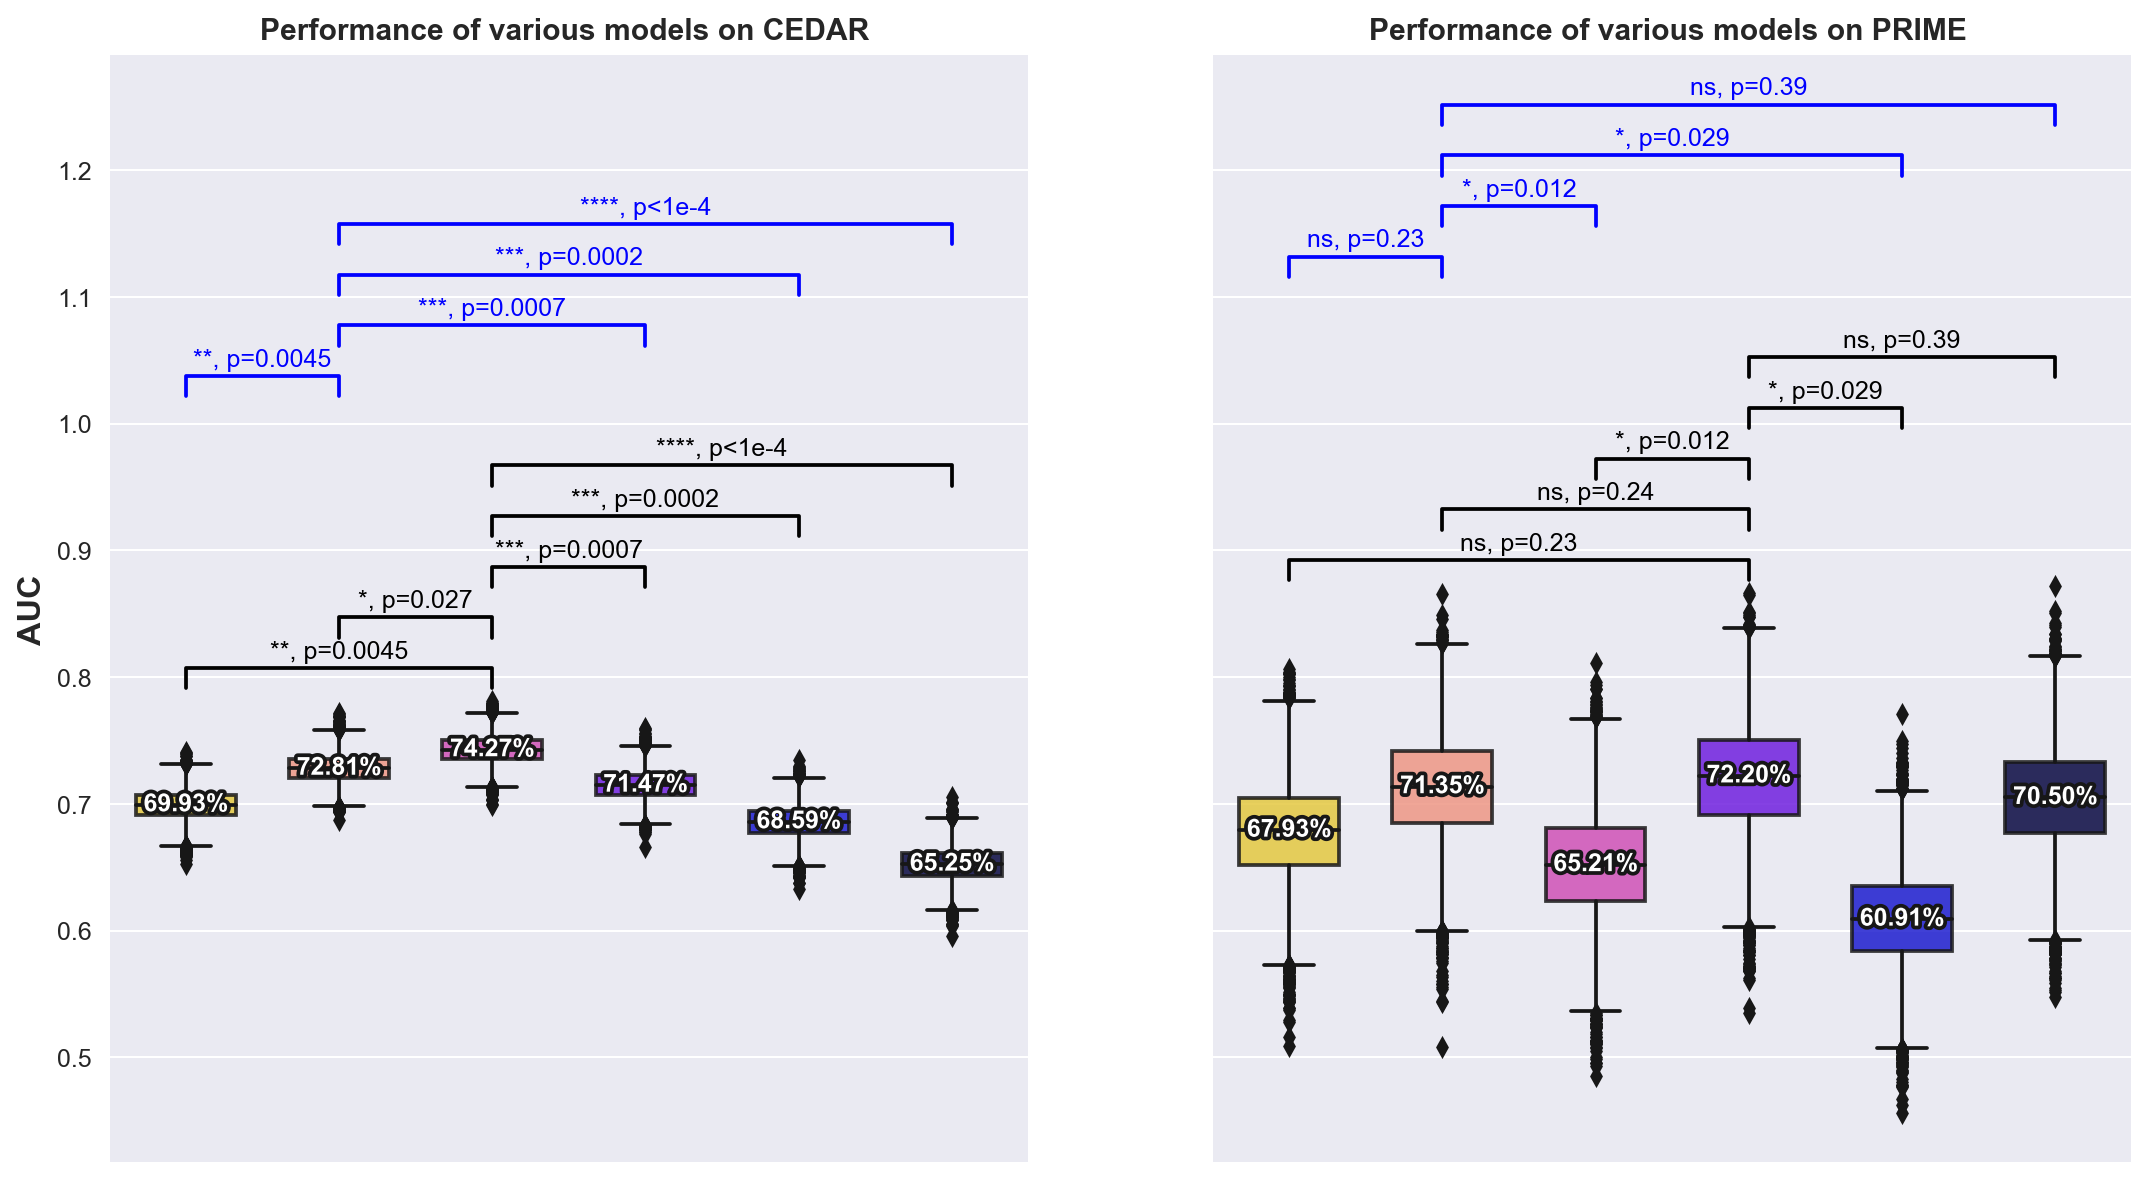

In [150]:
from src.bootstrap import get_pval, plot_pval
# Redo the plot but keeping the order and redo not all the p-values, using the new features (i.e. including foreignness score etc)
f,a = plt.subplots(1,2, figsize=(14.5,8), sharey=True)
order = ['Base Model','General Model', 'Optimal CEDAR Model', 'Optimal PRIME Model (sig)', 'NNAlign', 'PRIME']
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
color_order = {k:v for k,v in zip(order, get_palette('gnuplot2_r', n_colors=len(order)))}
for evalset,axis in zip(rebootstrapped_best, a):
    tmp = rebootstrapped_best[evalset].query('condition in @order').copy()
    sorted_order = tmp.groupby('condition').agg(mean_auc=('auc','mean'))\
                                               .sort_values('mean_auc', ascending=False).index.str.replace('nnalign', 'NNAlign').tolist()
    # Sort order by decreasing performance
    # tmp['key'] = tmp['key'].replace('nnalign', 'NNAlign')
    # tmp['key'] = tmp['key'].str.replace(' model', ' Model')
    sns.boxplot(data = tmp , x = 'condition', y = 'auc', width=.65, ax=axis, 
                palette = color_order, order = order, hue = 'condition', dodge=False)
    # Add median and remove legend / ylabel
    add_median_labels(axis, fmt = '.2%');
    axis.legend([], frameon=False);
    axis.set_ylabel('');
    axis.set_xlabel('');
    # axis.set_xticklabels(axis.get_xticklabels(), fontweight = 'semibold', fontsize=13, rotation=45, ha='center')
    axis.set_xticklabels([])
    axis.set_title(f'Performance of various models on {evalset.upper()} ', fontweight='semibold')
    # Comparing with aucs_base, which is the best one
    best = tmp.groupby('condition').agg(mean_auc=('auc','mean')).idxmax().item()
    aucs_base = tmp.query('condition == @best').auc.values
    h, h0 = 0.01, 0.02
    x0 = order.index(best)
    plt.setp(axis.patches, alpha=0.85)
    comp_list = reversed([x for x in order if x != best]) if x0 >= 4 else [x for x in order if x != best]
    for i, comparison in enumerate(comp_list):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('condition == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        # print(evalset,best, 'here',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_base)+h, h=h0, color='k')
        h += 2 * h0
        
    # Comparing "agg_selection" with the lower 2
    new_order = [x for x in order if x != best and x != 'General Model']
    new_order = ['General Model'] + new_order
    aucs_agg = tmp.query('condition == "General Model"').auc.values
    x0 = order.index('General Model')
    h += 2*h0
    for i, comparison in enumerate(new_order[1:]):
        x1 = order.index(comparison)
        aucs_comp = tmp.query('condition == @comparison').auc.values
        pval, sig = get_pval(aucs_base, aucs_comp)
        # print(evalset,best, 'there',comparison, round(pval,3))
        plot_pval(axis, pval, sig, x0, x1, y = max(aucs_agg)+h, h=h0, color = 'b')
        h += 2*h0
a[0].set_ylabel('AUC', fontweight='semibold', fontsize=13);

# Just re-order legend because it got messed up for some reasons
h, l = a[1].get_legend_handles_labels()
new_h = [h.pop(l.index('Base Model')), h.pop(l.index('General Model'))]
new_l = [l.pop(l.index('Base Model')), l.pop(l.index('General Model'))]
new_h.extend(h)
new_l.extend(l)

bbox = (0, 0.59)
a[1].legend(new_h, new_l, bbox_to_anchor = bbox,prop=dict(weight='semibold', size = 14));
f.tight_layout()
# NUMBER PRINTED IS NOT THE MEAN BUT THE MEDIAN THAT'S WHY THEY ARE DIFFERENT FROM THE DF
# f.savefig('../../../writing/230131_cedar_paper_1/figures/230330_xxredone_best_models_compromise_WITHCEDARFILTERING.png', bbox_inches='tight', dpi=200)

## feat imps

In [972]:
cedar_cdt='onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM'
prime_cdt='cedar_onehot_Mask_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score'
comp_cdt = 'cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total_Gene_TPM'

df_fi_expr_comp=pd.read_csv(f'../output/230308_aligned_exprscore_addwtrank_foreignness/raw/featimps_{comp_cdt}.csv')
df_fi_expr_cedar=pd.read_csv(f'../output/230327_fixing_exprscore_filt/raw/featimps_{cedar_cdt}.csv')
df_fi_expr_prime=pd.read_csv(f'../output/230308_aligned_exprscore_addwtrank_foreignness/raw/featimps_{prime_cdt}.csv')

In [977]:
len(df_fi_expr_cedar.T), len(df_fi_expr_prime.T), len(df_fi_expr_comp.T)

(33, 23, 24)

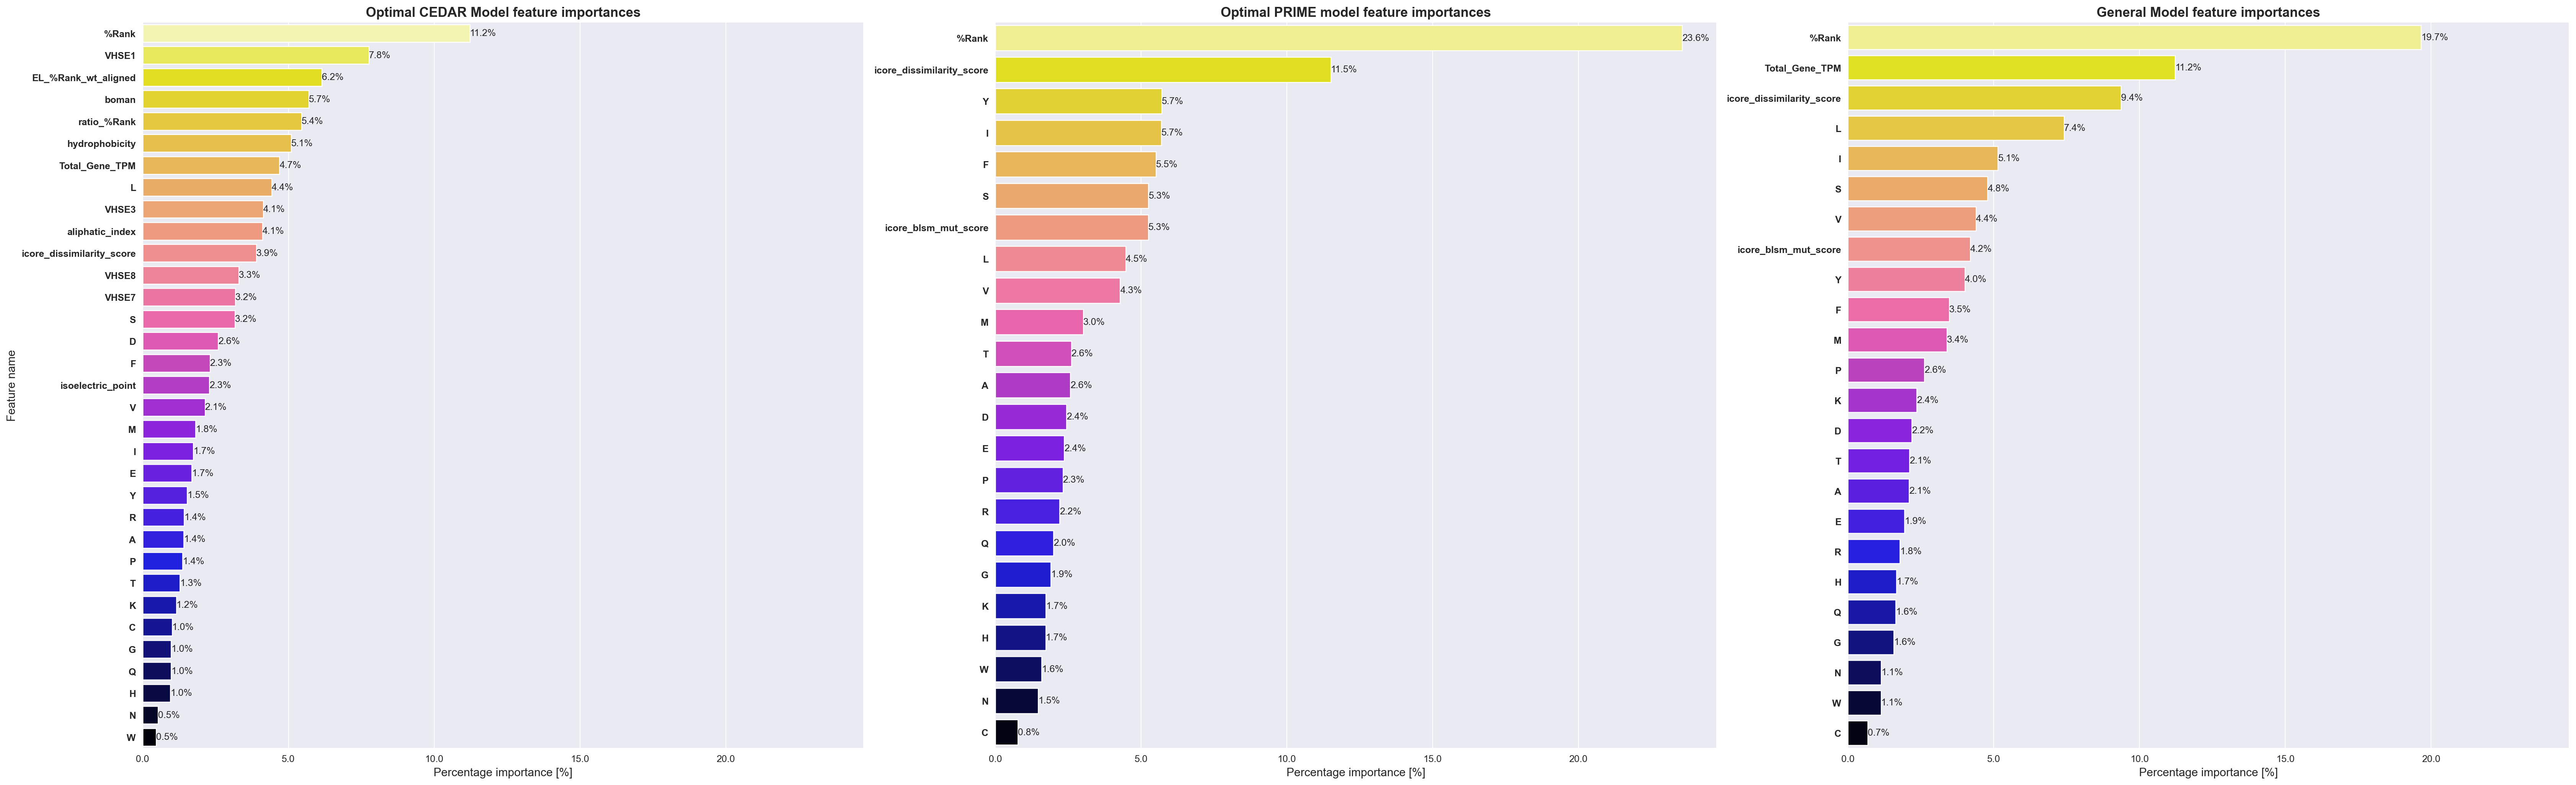

In [973]:
from src.metrics import plot_feature_importance
f,a = plt.subplots(1,3, figsize=(37.5,11.5), sharex=True)
plot_feature_importance(df_fi_expr_cedar.values.flatten(), 
                        df_fi_expr_cedar.columns.str.replace('rank','%Rank'),
                        palette='gnuplot2_r', ax=a[0], title='Optimal CEDAR Model feature importances', label_number=True)
plot_feature_importance(df_fi_expr_comp.values.flatten(), 
                        df_fi_expr_comp.columns.str.replace('rank','%Rank'), 
                        palette='gnuplot2_r', ax=a[2], title='General Model feature importances', label_number=True)
plot_feature_importance(df_fi_expr_prime.values.flatten(), 
                        df_fi_expr_prime.columns.str.replace('rank','%Rank'),
                        palette='gnuplot2_r', ax=a[1], title='Optimal PRIME model feature importances', label_number=True)
a[1].set_ylabel(None)
a[2].set_ylabel(None)
for ax in a.ravel():
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='semibold')
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/featimps_allmodels.png', bbox_inches='tight', dpi=250)


## final figure

# Other dataset checks:

- Core vs icore, npeps for IC

- improved binders...